## Final Project

In this project, I aim determine where historical tree density is determined by precipitation, and where precipiation does not predict historical tree density. I specifically aim to answer: Where is this distribution is determined by precipitation (and other dimensions of climate space), and where might fire & other disturbances (that we dont have data on) have played a role?

The following dataset is preprocessed in R, with the preprocessing steps found here: https://github.com/Kah5/biomodality 
The dataset is structured such that each instance is a data point where we estimated density from data on two trees collected by the public land surveyors at or before the time of 'european settlement' in Indiana & Illinois. Points are assigned to a 8-km raster grid in space to reduce noise from individual points. 

PLS data: The Public Land Survey (PLS) was originally commissioned by the US General Land Office to survey timber and land parcels for the purpose of creating land titles for early European settler purchase. PLS surveyors placed posts every ½ mile a regular grid across the US and recorded the species, diameter, distance, and direction to the nearest two (or four, occasionally) trees. Since surveys were conducted at or before the time of European settlement in the state, the time of surveys varied depending on state or region. PLS data was digitized by our lab at Notre Dame and University of Wisconsin. We estimate species density and biomass at the PLS survey point level, and aggregate up to an 8km grid for spatial modeling. Density is estimated from the distance and direction to the first two trees at each point using a Morisita density estimator, and state level survey correction estimates from Charlie Cogbill (Cogbill et al. 2002, Goring et al. 2015). 

Environmental covariate data: In this analysis, we will use seasonally averaged temperature and precipitation data from 1901-1910 derived from the National Historic Climate Network gridded product. Soil hydrology parameters (%clay, %sand, %silt, available water content (awc), saturated hydraulic conductivity (ksat), and drainage class) are aggregated the USGS STATSGO soil database. Average distance to river was calculated in QGIS from the USGS River and Waterbody dataset and rasterized in R. Elevation from the 30m National Elevation Dataset DEM was used to create Elevation, Topographic Convergence Index, and Slope covariates. All covariates were aggregated to 8km grids to match the resolution of modeled pre-settlement biomass

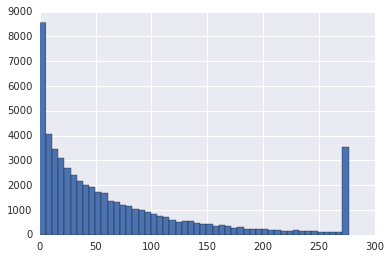

In [368]:
%matplotlib inline
import numpy as np
import pandas as pd
data = pd.read_csv("data/spec_table_30yr_prism.csv")
data.head()
data['density'].hist(bins = 50)
#note that the pr30yr is the highest resolution precipitation data that we have from prism. We will use this precipitation metric in the following models
#regressions draw from code from this tutorial
#http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/

Data is ordered such that each instance is representative of a single tree that the surveyers recorded. each tree has x-y coordinates TreeX and TreeY, while each survey point has vlaues pointx and pointy. The X and Y values correspond to the spatial centroid corrdinates of the rasterized grid cells that the survey points belong to. 



In [369]:
#import the smaller resolution precipitation data for each grid cell
precip = pd.read_csv('data/pr_monthly_Prism_1895_1905.csv')
#import the temperature data from each grid cell
temp = pd.read_csv('data/tmean_monthly_Prism_1895_1905.csv')
#read in csv from full midwest that has data from soils data
covar = pd.read_csv('data/covariates_full_extract_v2.csv')
covar.head()

Unnamed: 0   cell      x       y    total_pr      jja_pr  total_tmean  \
0           1  23682 -59000  854000  660.000000  271.000000    74.018725   
1           2  23386 -59000  862000  654.860126  266.809784    73.558974   
2           3  23090 -59000  870000  647.749870  264.749870    72.916679   
3           4  22794 -59000  878000  647.000000  264.000000    69.861049   
4           5  22498 -59000  886000  636.393440  260.695641    69.700314   

    jja_tmean    ksat  clay  sand       silt   awc         DEM  
0  213.796499     NaN   NaN   NaN        NaN   NaN  458.544423  
1  214.046153  2.8229  32.5   6.2  61.299999  0.19  453.690405  
2  213.403936  9.1743  23.5   7.0  69.500000  0.21  441.086460  
3  210.517268     NaN   NaN   NaN        NaN   NaN  477.833696  
4  211.001628     NaN   NaN   NaN        NaN   NaN  461.385199

In [370]:
#now we need to merge the dataframes so that we join data based on x and y

df= pd.merge(data, covar[['x','y','ksat','sand','jja_tmean','jja_pr','DEM','awc']], how='left', on=['x','y'])
df = pd.merge(df, precip, how = 'left', on=['x','y'])
df = pd.merge(df, temp, how = 'left', on = ['x','y'])
df.head()

Unnamed: 0_x     X       x       y   cell       PointX       PointY  \
0             1  4231  869000  526000  35934  865914.4500  523313.3900   
1             2  4234  781000  550000  35035  777920.2528  546454.9313   
2             3  4235  693000  574000  34136  693310.9075  576172.1190   
3             4  4237  781000  550000  35035  778019.2353  549680.2162   
4             5  4244  749000  574000  34143  752838.1400  571267.1100   

         TreeX        TreeY      spec     ...         Apr_._y     May_._y  \
0  865914.4500  523313.3900  Ironwood     ...             NaN         NaN   
1  777920.2528  546454.9313     Beech     ...       97.115639  155.264957   
2  693310.9075  576172.1190      Pine     ...       83.232158  163.407935   
3  778019.2353  549680.2162       Elm     ...       97.115639  155.264957   
4  752838.1400  571267.1100       Oak     ...       88.160159  164.692135   

      Jun_._y     Jul_._y     Aug_._y    Sep_._y    Oct_._y    Nov_._y  \
0         NaN         NaN         NaN        NaN        NaN        NaN   
1  113.207388  110.390396  118.225899  88.537066  79.559741  70.779334   
2  117.571722  112.077056   91.075875  91.773300  61.776014  69.320941   
3  113.207388  110.390396  118.225899  88.537066  79.559741  70.779334   
4   83.339234  125.862516  101.042809  91.883051  52.539861  66.344419   

     Dec_._y    total_._y  
0        NaN          NaN  
1  46.777395  1032.301697  
2  39.755285   979.158333  
3  46.777395  1032.301697  
4  40.390203   978.335709  

[5 rows x 59 columns]

In [371]:
#do cluster analysis on precip, temp, soils, and density features


#need to remove NaN values
X = df[['pr30yr','total_._y','total_._x','jja_pr','ksat', 'sand','awc','jja_tmean','DEM','density','spec','cell','x','y']]

#Bin data based on previously determined low, high and intermediate tree covers:
cut_points = [0,55,85,400] # these cut points represent the density cut offs for low, intermediate, and high density
labels = ["1","2","3"]
#X["dens_Bin"] = binning(X["density"], cut_points, labels)
#print pd.value_counts(X['dens_Bin'], sort=False)

X['dens_code'] = pd.cut(X['density'],bins=cut_points,labels=labels)
from sklearn import preprocessing

spec_dum_m = preprocessing.LabelEncoder()
X['spec_dum'] = spec_dum_m.fit_transform(X.spec)
#to convert back
#spec_m = spec_dum_m.inverse_transform(X.spec_dum)

X = X.dropna()


X.columns = ['pr30yr','precip1', 'precip','jja_pr' ,'ksat', 'sand','awc','jja_tmean','DEM','density','spec','cell','x','y','dens_code','spec_dum']
X.head()


pr30yr      precip1       precip      jja_pr       ksat       sand  \
1   979.951510  1032.301697  1032.301697  292.246498  28.228701  82.500000   
2   972.510864   979.158333   979.158333  296.516747  28.228701  69.099998   
3   979.098757  1032.301697  1032.301697  292.246498  28.228701  82.500000   
4  1000.790791   978.335709   978.335709  286.018028  28.228701  69.099998   
5   969.614074   949.267449   949.267449  301.550346  91.743202  93.599998   

    awc   jja_tmean         DEM     density   spec   cell       x       y  \
1  0.12  212.333333  257.485514   86.200602  Beech  35035  781000  550000   
2  0.13  216.333333  193.469827  276.743474   Pine  34136  693000  574000   
3  0.12  212.333333  257.485514  174.552618    Elm  35035  781000  550000   
4  0.13  216.312541  210.183900   20.270470    Oak  34143  749000  574000   
5  0.06  217.965912  204.807144    0.232335    Oak  36794  645000  502000   

  dens_code  spec_dum  
1         3         4  
2         3        22  
3         3        13  
4         1        20  
5         1        20

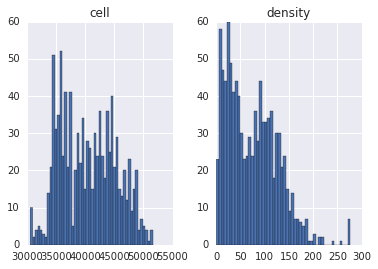

In [485]:
# when we average density across cells, we get a bimodal distribution in density 
#X['density'].hist()
mean_dens= X.groupby('cell', as_index= False)['density'].mean()
plt.figure(figsize=(14,7))
mean_dens.hist(bins = 50)

mean_precip= X.groupby('cell', as_index=False)['pr30yr'].mean()
#mean_precip.hist(bins = 50)
mean_dens.head()

mean_DEM=  X.groupby('cell', as_index=False)['DEM'].mean()
mean_awc=  X.groupby('cell', as_index=False)['awc'].mean()
mean_ksat=  X.groupby('cell', as_index=False)['ksat'].mean()

mean_jjatmean=  X.groupby('cell', as_index=False)['jja_tmean'].mean()
cut_points = [0,55,85,400] # these cut points represent the density cut offs for low, intermediate, and high density
labels = ["1","2","3"]
#X["dens_Bin"] = binning(X["density"], cut_points, labels)
#print pd.value_counts(X['dens_Bin'], sort=False)

mean_dens['dens_code'] = pd.cut(mean_dens['density'],bins=cut_points,labels=labels)



#now combine all into data from mean_dens
mean_dens['pr30yr'] = mean_precip['pr30yr']
mean_dens['jja_tmean'] = mean_jjatmean['jja_tmean']
mean_dens['DEM'] = mean_DEM['DEM']
mean_dens['ksat'] = mean_ksat['ksat']
mean_dens['awc'] = mean_awc['awc']

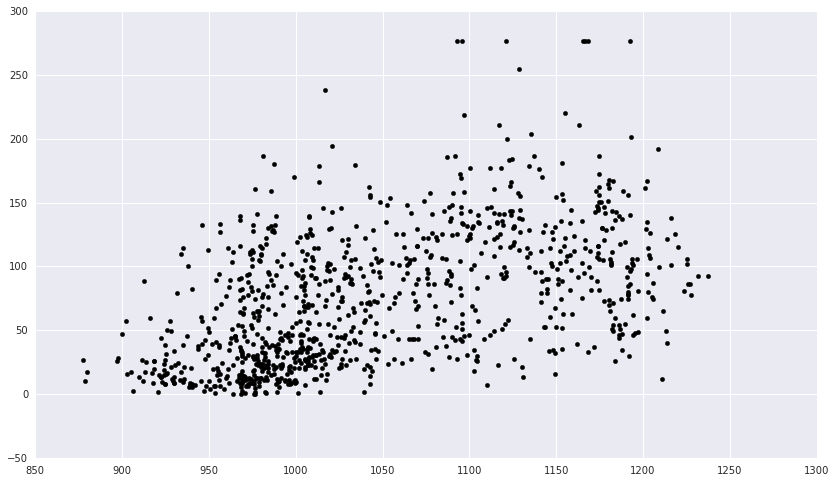

In [373]:
plt.figure( figsize=(14, 8))
plt.scatter(mean_precip['pr30yr'], mean_dens['density'],  color='black')

In [ ]:
In this scatter plot, the data are aggregated by cell, and demonstrate less scatter

# K-means clustering as more data exploration

Here I am exploring the data to see if clustering by covariates visually clusters data into low, intermediate & high tree density groups

### Kmeans with ksat, precipitaiton & elevation

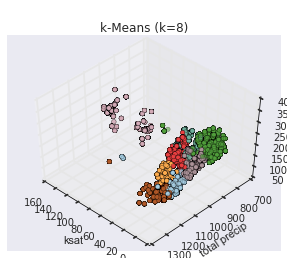

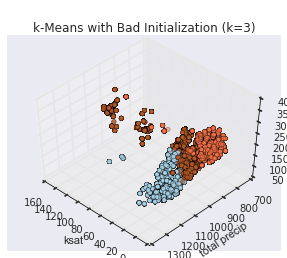

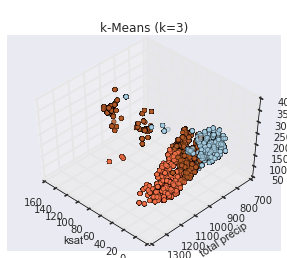

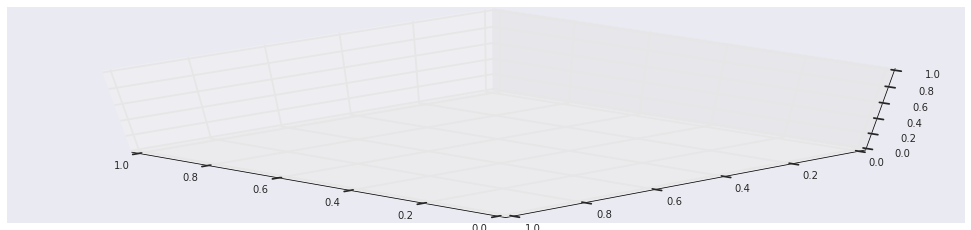

In [514]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pylab as plt
from sklearn import datasets
from sklearn.cluster import KMeans

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
import pylab as plt
# Define a set of k-means estimators.
estimators = {'k-Means (k=3)': KMeans(n_clusters=3),
              'k-Means (k=8)': KMeans(n_clusters=8),
              'k-Means with Bad Initialization (k=3)': KMeans(n_clusters=3, n_init=1,
                                                             init='random')}

fignum = 1
for name, est in estimators.items():
    # Define a matplotlib figure.
    fig = plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    
    plt.cla()

    # Fit the estimator.
    est.fit(X[['ksat', 'precip', 'DEM']])
    labels = est.labels_

    # Define a scatterplot.
    ax.scatter( X['ksat'], X['precip'],X['DEM'], c=labels.astype(np.float))

    # Customize the plot.
    #ax.w_xaxis.set_ticklabels([])
    #ax.w_yaxis.set_ticklabels([])
    #ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('ksat')
    ax.set_ylabel('total precip')
    ax.set_zlabel('DEM')
    plt.title("\n" + name + "\n")
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(14, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
plt.show()

### kmeans with precipitation, summer temperature, and elevation

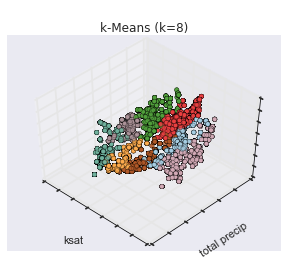

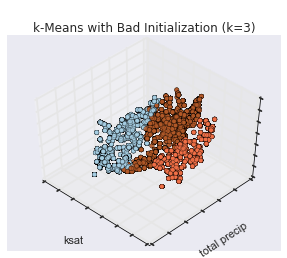

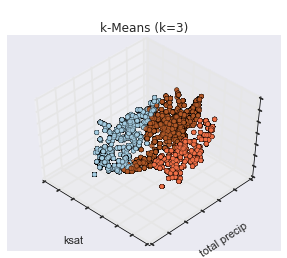

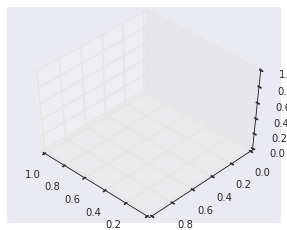

In [375]:
#now lets do this for precip, total_tmean, and sand
np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
import pylab as plt
# Define a set of k-means estimators.
estimators = {'k-Means (k=3)': KMeans(n_clusters=3),
              'k-Means (k=8)': KMeans(n_clusters=8),
              'k-Means with Bad Initialization (k=3)': KMeans(n_clusters=3, n_init=1,
                                                             init='random')}

fignum = 1
for name, est in estimators.items():
    # Define a matplotlib figure.
    fig = plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    
    plt.cla()

    # Fit the estimator.
    est.fit(X[['precip', 'jja_tmean', 'DEM']])
    labels = est.labels_

    # Define a scatterplot.
    ax.scatter( X['precip'], X['jja_tmean'],X['DEM'], c=labels.astype(np.float))

    # Customize the plot.
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('ksat')
    ax.set_ylabel('total precip')
    ax.set_zlabel('sand')
    plt.title("\n" + name + "\n")
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
plt.show()

## K-means clustering of Precipitation and Elevation

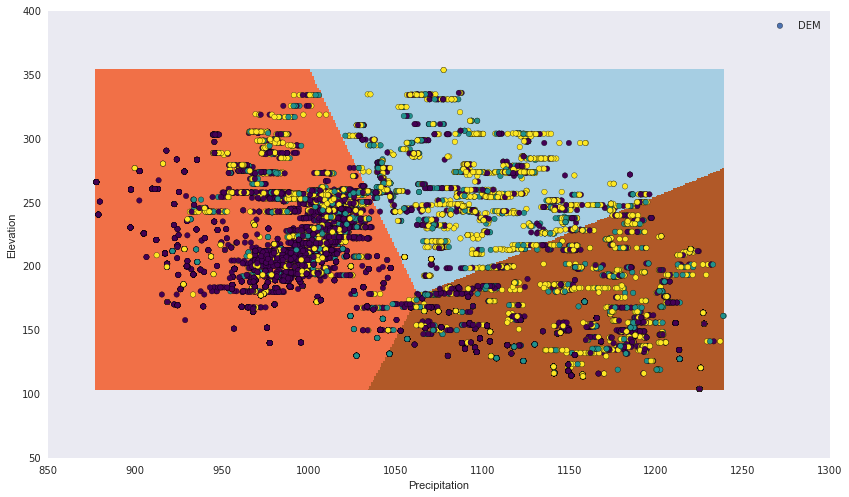

In [515]:
#color by high, low and intermediate density

knn=KMeans(n_clusters=3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'DEM']], X[['dens_code','spec_dum']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train)
# Make point predictions on the test set using the fit model.
#predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.DEM.min() - .5, x_test.DEM.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['ksat'], x_test['precip'], c = )
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure( figsize=(14, 8))
plt.figure(1, figsize=(14, 8))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test['pr30yr'], x_test['DEM'], c=y_test['dens_code'], s=30, cmap='viridis')
# Plot also the training points
plt.xlabel('Precipitation')
plt.ylabel('Elevation')
plt.legend()

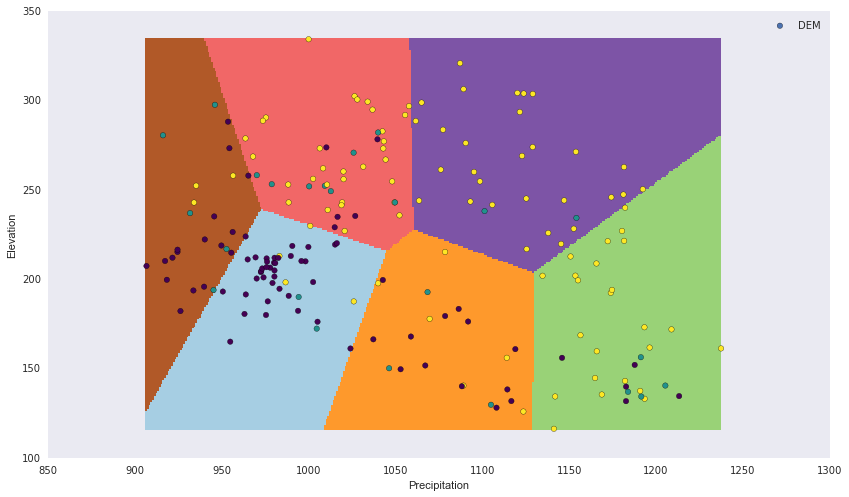

In [520]:
#color by high, low and intermediate density

knn=KMeans(n_clusters=6)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mean_dens[['pr30yr', 'DEM']], mean_dens[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train)
# Make point predictions on the test set using the fit model.
#predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.DEM.min() - .5, x_test.DEM.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['ksat'], x_test['precip'], c = )
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure( figsize=(14, 8))
plt.figure(1, figsize=(14, 8))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test['pr30yr'], x_test['DEM'], c=y_test['dens_code'], s=30, cmap='viridis')
# Plot also the training points
plt.xlabel('Precipitation')
plt.ylabel('Elevation')
plt.legend()

### K-Nearest Neighbors Classification for survey point level data

In [449]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import roc_curve, auc

#define a generic function to split the test data with an index for random state
def split_tests(x, y, clf_class,**kwargs):

    #split the data into testing and training datasets
    x_train, x_test, y_train, y_test = train_test_split(x, y,  test_size=0.20, train_size = 0.80, random_state=43)
    # Fit the model on the training data.
    
    clf = clf_class(**kwargs)
    clf.fit(x_train,y_train)
    # Make point predictions on the test set using the fit model.
    predictions =  clf.predict(x_test)
    #auroc = roc_auc_score(y_test ,predictions)
    
    print (accuracy_score(y_test, predictions))
    #print (auroc)
    
    
#use the split_tests defined function to compare the knn classifier and decision tree
#print 'KNN accuracy score:'
split_tests(X[['pr30yr','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.625102170557


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.645717918445
0.672600127146
0.664971392244


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [496]:
split_tests(X[['ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.609935519026


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.630187993824


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.633729906457


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.636454454636


In [434]:
split_tests(X[['pr30yr','awc']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','awc']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','awc']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','awc']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.59249841068


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.613477431659


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.636817727727


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.632730905458


In [435]:
split_tests(X[['pr30yr','ksat']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','ksat']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','ksat']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','ksat']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.599945509036


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.625102170557


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.645263827082


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.640087185542


In [436]:
split_tests(X[['pr30yr','jja_tmean']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','jja_tmean']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','jja_tmean']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','jja_tmean']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.614476432658


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.639723912451


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.668785759695


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.666878575969


In [437]:
split_tests(X[['pr30yr','jja_tmean','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','jja_tmean','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','jja_tmean','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','jja_tmean','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.63073290346


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.652710925438


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.680592135138


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.676686949414


In [438]:
split_tests(X[['pr30yr','jja_tmean','DEM','ksat']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','jja_tmean','DEM','ksat']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','jja_tmean','DEM','ksat']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','jja_tmean','DEM','ksat']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.627554263918


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.653255835074


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.680228862047


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.676051221506


In [457]:
split_tests(X[['pr30yr','jja_tmean','DEM','awc']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','jja_tmean','DEM','awc']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','jja_tmean','DEM','awc']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','jja_tmean','DEM','awc']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.63073290346


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.652620107166


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.680592135138
0.676686949414


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [458]:
split_tests(X[['pr30yr','jja_tmean','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','jja_tmean','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','jja_tmean','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','jja_tmean','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.63073290346


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.652710925438


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.680592135138
0.676686949414


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [459]:
split_tests(X[['pr30yr','ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['pr30yr','ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['pr30yr','ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['pr30yr','ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.624557260921


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.650168013804


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.676686949414


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.672327672328


In [461]:
split_tests(X[['jja_tmean','ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['jja_tmean','ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['jja_tmean','ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['jja_tmean','ksat','DEM']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.612205975842


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.629279811098


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.625192988829


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.637362637363


In [462]:
split_tests(X[['jja_tmean','ksat','pr30yr']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(X[['jja_tmean','ksat','pr30yr']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(X[['jja_tmean','ksat','pr30yr']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(X[['jja_tmean','ksat','pr30yr']], X[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.63073290346


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.646444464626


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.669058214513


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.664608119154


### K Nearest Neighbors classification for aggregated 8km grid cell level data

In [486]:
split_tests(mean_dens[['pr30yr','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.698492462312
0.693467336683
0.718592964824
0.723618090452


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [497]:
split_tests(mean_dens[['ksat','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['ksat','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['ksat','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['ksat','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.552763819095
0.532663316583
0.542713567839
0.552763819095


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [499]:
split_tests(mean_dens[['awc','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['awc','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['awc','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['awc','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.502512562814
0.517587939698
0.492462311558


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.51256281407


In [487]:
split_tests(mean_dens[['pr30yr','awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.547738693467
0.577889447236
0.613065326633
0.597989949749


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [488]:
split_tests(mean_dens[['pr30yr','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.592964824121
0.577889447236
0.618090452261
0.608040201005


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [489]:
split_tests(mean_dens[['pr30yr','jja_tmean']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','jja_tmean']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','jja_tmean']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','jja_tmean']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.658291457286
0.673366834171
0.663316582915
0.678391959799


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [491]:
split_tests(mean_dens[['pr30yr','jja_tmean','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','jja_tmean','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','jja_tmean','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','jja_tmean','DEM']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.718592964824
0.698492462312
0.70351758794
0.718592964824


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [492]:
split_tests(mean_dens[['pr30yr','jja_tmean','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','jja_tmean','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','jja_tmean','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','jja_tmean','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.688442211055
0.713567839196
0.708542713568
0.713567839196


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [493]:
split_tests(mean_dens[['pr30yr','jja_tmean','awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','jja_tmean','awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','jja_tmean','awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','jja_tmean','awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.658291457286
0.673366834171
0.663316582915
0.678391959799


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [494]:
split_tests(mean_dens[['pr30yr','jja_tmean','DEM', 'ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','jja_tmean','DEM', 'ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','jja_tmean','DEM', 'ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','jja_tmean','DEM', 'ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.688442211055
0.698492462312
0.70351758794
0.70351758794


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [500]:
split_tests(mean_dens[['pr30yr','DEM','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','DEM','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','DEM','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','DEM','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.673366834171
0.693467336683
0.70351758794
0.718592964824


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [501]:
split_tests(mean_dens[['jja_tmean','DEM','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['jja_tmean','DEM','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['jja_tmean','DEM','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['jja_tmean','DEM','ksat']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.592964824121
0.577889447236
0.613065326633
0.613065326633


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [495]:
split_tests(mean_dens[['pr30yr','jja_tmean','DEM', 'awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 3)  
split_tests(mean_dens[['pr30yr','jja_tmean','DEM', 'awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 4) 
split_tests(mean_dens[['pr30yr','jja_tmean','DEM', 'awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 5) 
split_tests(mean_dens[['pr30yr','jja_tmean','DEM', 'awc']], mean_dens[['dens_code']], KNeighborsClassifier, n_neighbors = 6) 

0.718592964824
0.698492462312
0.70351758794
0.718592964824


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Precipitation and elevation classifier

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.63627281809099989

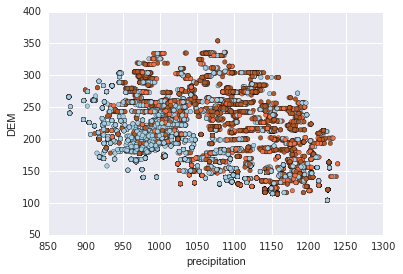

In [389]:
#color by high, low and intermediate density
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'DEM']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.DEM.min() - .5, x_test.DEM.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['TT4'], x_test['TSH'], c = )
Z = knnc.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(4, 3))
#plt.set_cmap(plt.cm.Paired)
#plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)

plt.scatter(x_test['pr30yr'], x_test['DEM'], c = y_test )
# Plot also the training points
plt.xlabel('precipitation')
plt.ylabel('DEM')



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AttributeError: 'str' object has no attribute 'view'

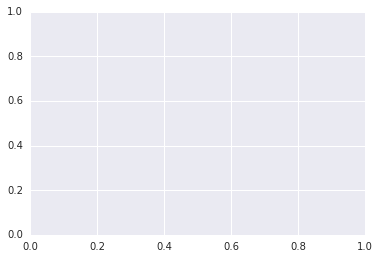

In [513]:
# do this for the aggregated dataset too
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 6)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mean_dens[['pr30yr', 'DEM']], mean_dens[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.DEM.min() - .5, x_test.DEM.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['TT4'], x_test['TSH'], c = )
Z = knnc.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(14, 7))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)

plt.scatter(x_test['pr30yr'], x_test['DEM'], c = y_test )
# Plot also the training points
plt.xlabel('precipitation')
plt.ylabel('DEM')



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

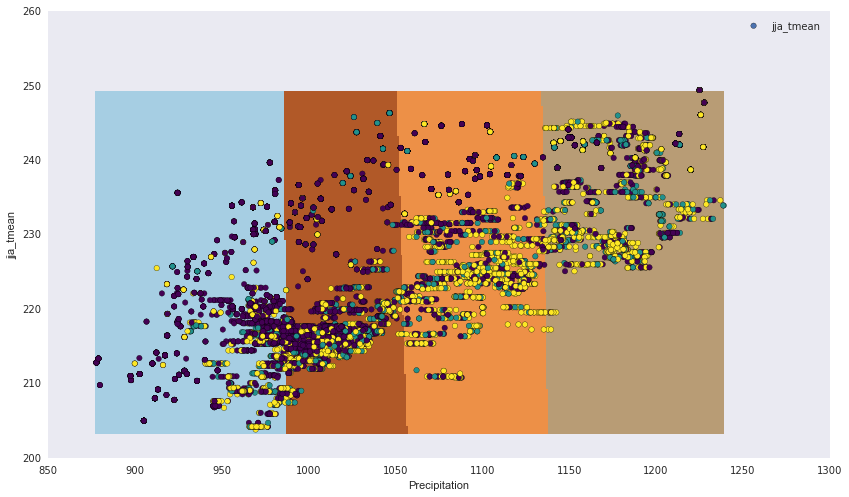

In [391]:
#color by high, low and intermediate density

knn=KMeans(n_clusters=4)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'jja_tmean']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train)
# Make point predictions on the test set using the fit model.
#predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.jja_tmean.min() - .5, x_test.jja_tmean.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['ksat'], x_test['precip'], c = )
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure( figsize=(14, 8))
plt.figure(1, figsize=(14, 8))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test['pr30yr'], x_test['jja_tmean'], c=y_test['dens_code'], s=30, cmap='viridis')
# Plot also the training points
plt.xlabel('Precipitation')
plt.ylabel('jja_tmean')
plt.legend()


C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.6228317137408047

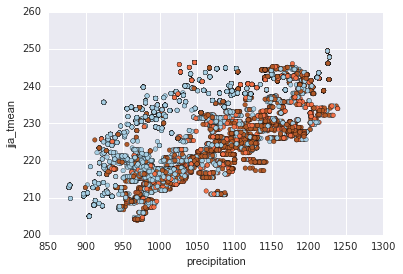

In [392]:
#color by high, low and intermediate density
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'jja_tmean']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.jja_tmean.min() - .5, x_test.jja_tmean.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['TT4'], x_test['TSH'], c = )
Z = knnc.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(4, 3))
#plt.set_cmap(plt.cm.Paired)
#plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)

plt.scatter(x_test['pr30yr'], x_test['jja_tmean'], c = y_test )
# Plot also the training points
plt.xlabel('precipitation')
plt.ylabel('jja_tmean')



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.65761511216056667

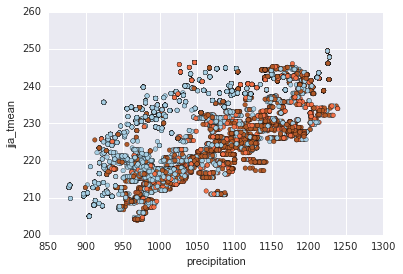

In [410]:
#color by high, low and intermediate density
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 8)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'jja_tmean']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.jja_tmean.min() - .5, x_test.jja_tmean.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['TT4'], x_test['TSH'], c = )
Z = knnc.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(4, 3))
#plt.set_cmap(plt.cm.Paired)
#plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)

plt.scatter(x_test['pr30yr'], x_test['jja_tmean'], c = y_test )
# Plot also the training points
plt.xlabel('precipitation')
plt.ylabel('jja_tmean')



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

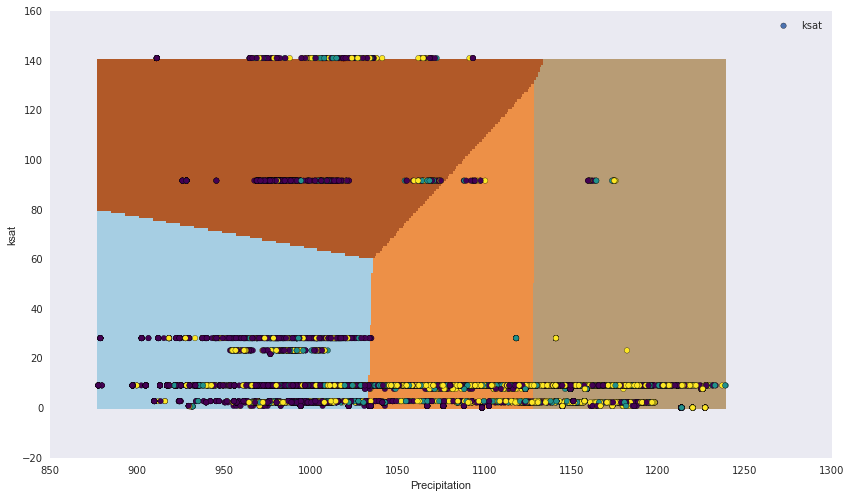

In [313]:
#color by high, low and intermediate density

knn=KMeans(n_clusters=4)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'ksat']], X[['dens_code','spec_dum']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train)
# Make point predictions on the test set using the fit model.
#predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.ksat.min() - .5, x_test.ksat.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['ksat'], x_test['precip'], c = )
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure( figsize=(14, 8))
plt.figure(1, figsize=(14, 8))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test['pr30yr'], x_test['ksat'], c=y_test['dens_code'], s=30, cmap='viridis')
# Plot also the training points
plt.xlabel('Precipitation')
plt.ylabel('ksat')
plt.legend()

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.60621196984833348

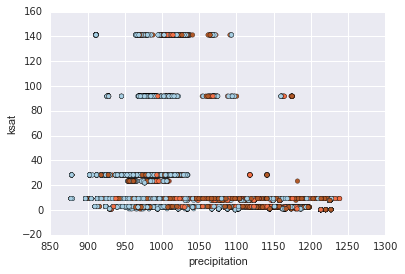

In [393]:
#color by high, low and intermediate density
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'ksat']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.ksat.min() - .5, x_test.ksat.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['TT4'], x_test['TSH'], c = )
Z = knnc.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(4, 3))
#plt.set_cmap(plt.cm.Paired)
#plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)

plt.scatter(x_test['pr30yr'], x_test['ksat'], c = y_test )
# Plot also the training points
plt.xlabel('precipitation')
plt.ylabel('ksat')



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

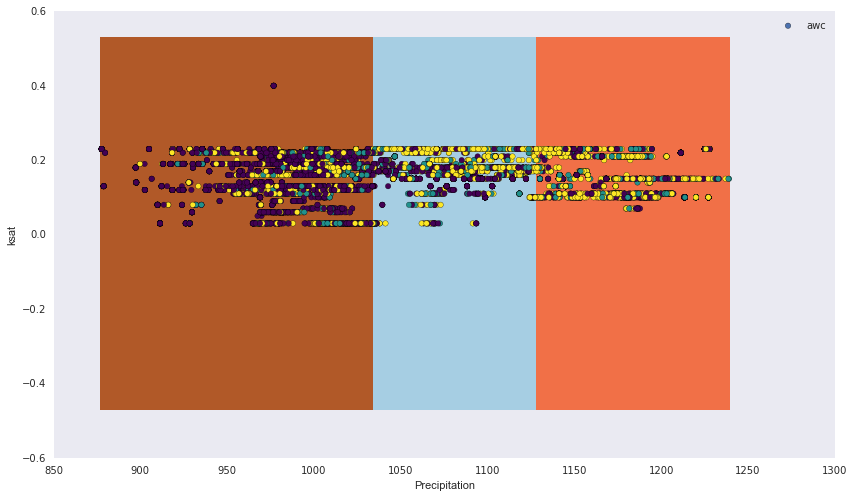

In [322]:
#color by high, low and intermediate density

knn=KMeans(n_clusters=3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'awc']], X[['dens_code','spec_dum']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train)
# Make point predictions on the test set using the fit model.
#predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.awc.min() - .5, x_test.awc.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['ksat'], x_test['precip'], c = )
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure( figsize=(14, 8))
plt.figure(1, figsize=(14, 8))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test['pr30yr'], x_test['awc'], c=y_test['dens_code'], s=30, cmap='viridis')
# Plot also the training points
plt.xlabel('Precipitation')
plt.ylabel('awc')
plt.legend()

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.60702933430206163

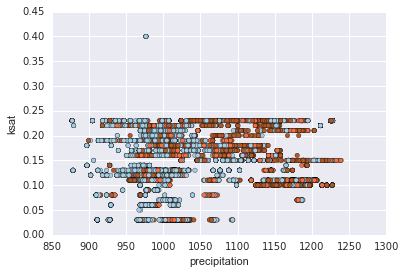

In [394]:
#color by high, low and intermediate density
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'awc']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.awc.min() - .5, x_test.awc.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['TT4'], x_test['TSH'], c = )
Z = knnc.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(4, 3))
#plt.set_cmap(plt.cm.Paired)
#plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)

plt.scatter(x_test['pr30yr'], x_test['awc'], c = y_test )
# Plot also the training points
plt.xlabel('precipitation')
plt.ylabel('ksat')



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

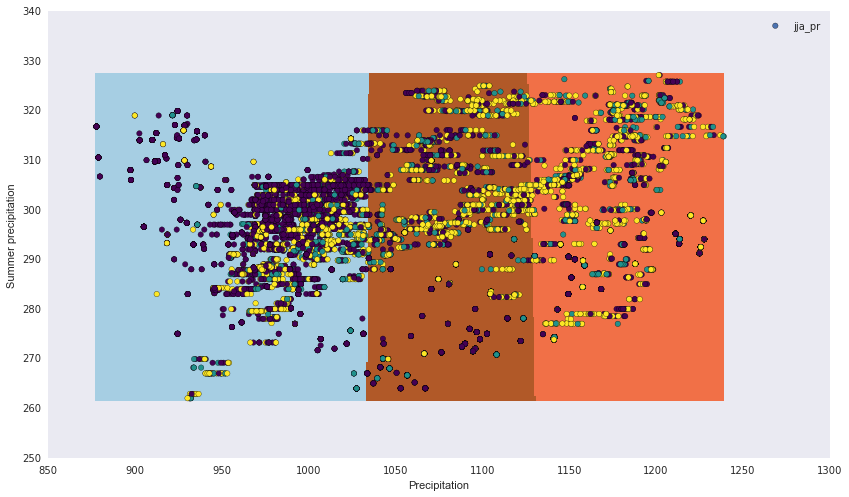

In [343]:
#color by high, low and intermediate density

knn=KMeans(n_clusters=3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'jja_pr']], X[['dens_code','spec_dum']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train)
# Make point predictions on the test set using the fit model.
#predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.jja_pr.min() - .5, x_test.jja_pr.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['ksat'], x_test['precip'], c = )
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure( figsize=(14, 8))
plt.figure(1, figsize=(14, 8))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test['pr30yr'], x_test['jja_pr'], c=y_test['dens_code'], s=30, cmap='viridis')
# Plot also the training points
plt.xlabel('Precipitation')
plt.ylabel('Summer precipitation')
plt.legend()

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.60702933430206163

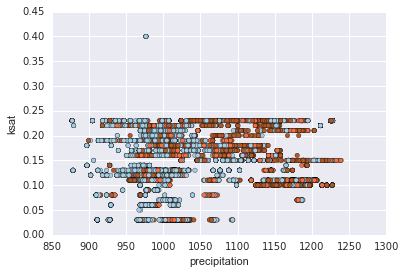

In [399]:
#color by high, low and intermediate density
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr', 'awc']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.awc.min() - .5, x_test.awc.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['TT4'], x_test['TSH'], c = )
Z = knnc.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(4, 3))
#plt.set_cmap(plt.cm.Paired)
#plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)

plt.scatter(x_test['pr30yr'], x_test['awc'], c = y_test )


# Plot also the training points
plt.xlabel('precipitation')
plt.ylabel('ksat')



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

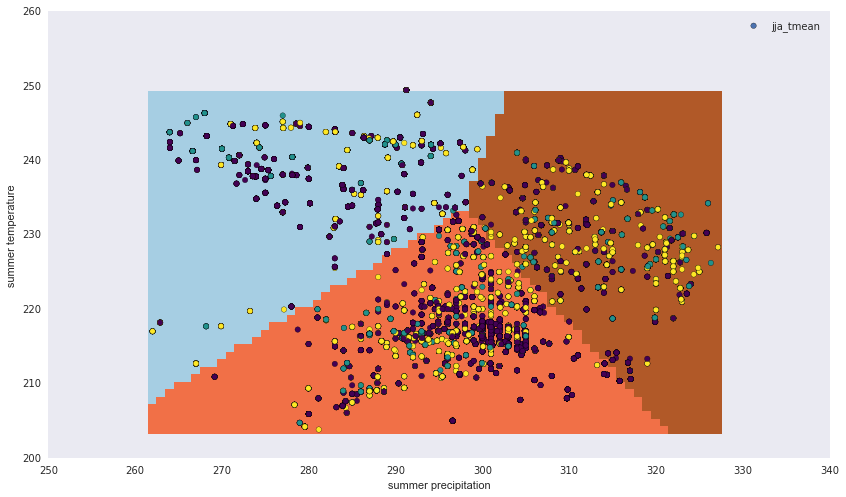

In [331]:
#color by high, low and intermediate density

knn=KMeans(n_clusters=3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['jja_pr', 'jja_tmean']], X[['dens_code','spec_dum']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train)
# Make point predictions on the test set using the fit model.
#predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.jja_pr.min() - .5, x_test.jja_pr.max() + .5
y_min, y_max = x_test.jja_tmean.min() - .5, x_test.jja_tmean.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['ksat'], x_test['precip'], c = )
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure( figsize=(14, 8))
plt.figure(1, figsize=(14, 8))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test['jja_pr'], x_test['jja_tmean'], c=y_test['dens_code'], s=30, cmap='viridis')
# Plot also the training points
plt.xlabel('summer precipitation')
plt.ylabel('summer temperature')
plt.legend()

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.61992552901643816

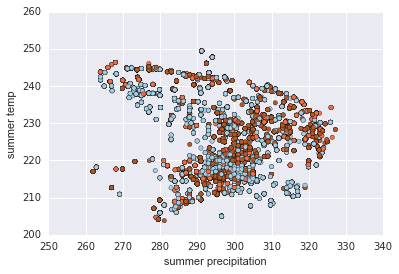

In [400]:
#color by high, low and intermediate density
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['jja_pr', 'jja_tmean']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.jja_pr.min() - .5, x_test.jja_pr.max() + .5
y_min, y_max = x_test.jja_tmean.min() - .5, x_test.jja_tmean.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['TT4'], x_test['TSH'], c = )
Z = knnc.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(4, 3))
#plt.set_cmap(plt.cm.Paired)
#plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)

plt.scatter(x_test['jja_pr'], x_test['jja_tmean'], c = y_test )


# Plot also the training points
plt.xlabel('summer precipitation')
plt.ylabel('summer temp')



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

In [401]:
#color by high, low and intermediate density
from sklearn.neighbors import KNeighborsClassifier
knnc=KNeighborsClassifier(n_neighbors= 3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['jja_pr', 'jja_tmean','DEM','ksat','awc']], X[['dens_code']],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1


#x_train
# Fit the model on the training data.

knnc.fit(x_train, y_train)
predictions = knnc.predict(x_test)



accuracy_score(y_test, predictions)
#roc_auc_score(y_test , predictions)

C:\Users\JMac\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.61329579511397692

In [359]:
mean_df  = dict(dens=mean_dens,dem=mean_DEM, pr=mean_precip) #pd.DataFrame(mean_dens,mean_DEM, mean_precip)
mean_dens['DEM'] = mean_DEM['DEM']
mean_dens['precip'] = mean_precip['pr30yr']
mean_dens['jja_tmean'] = mean_jjatmean['jja_tmean']
cut_points = [0,55,85,400] # these cut points represent the density cut offs for low, intermediate, and high density
labels = ["1","2","3"]


mean_dens['dens_code'] = pd.cut(mean_dens['density'],bins=cut_points,labels=labels)
mean_dens.head()

cell    density         DEM      precip   jja_tmean dens_code
0  30554   8.407117  290.772660  918.007600  208.446116         1
1  30560  26.065592  230.565148  897.297894  211.000000         1
2  30571  27.008817  260.782516  911.344904  207.995590         1
3  30848   1.585973  237.669070  920.826713  211.018895         1
4  30850  17.218778  260.768507  913.112303  209.174805         1

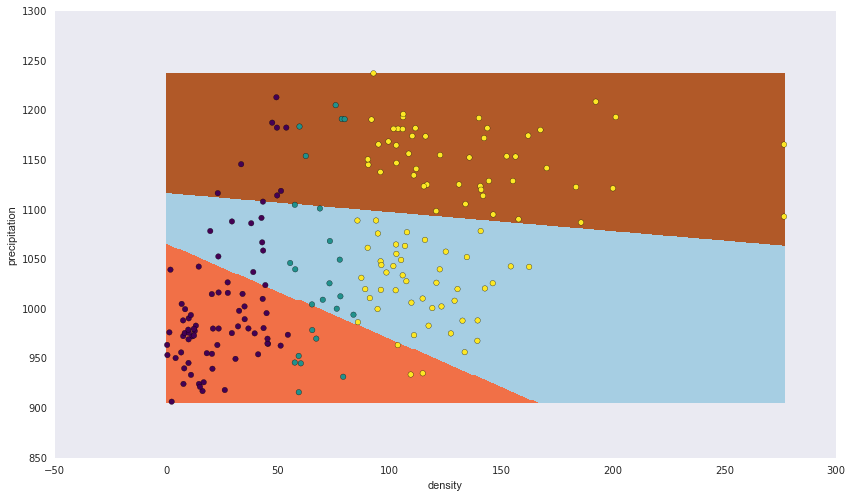

In [360]:
#color by high, low and intermediate density

knn=KMeans(n_clusters=3)
mean_df = pd.DataFrame(mean_dens,mean_DEM, mean_precip)

from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mean_dens[['density','precip']],mean_dens[['dens_code']] , test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train)
# Make point predictions on the test set using the fit model.
#predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.density.min() - .5, x_test.density.max() + .5
y_min, y_max = x_test.precip.min() - .5, x_test.precip.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#plt.scatter(x_test['ksat'], x_test['precip'], c = )
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure( figsize=(14, 8))
plt.figure(1, figsize=(14, 8))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy,Z)
plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test['density'], x_test['precip'], c=y_test['dens_code'], s=30, cmap='viridis')
#sct=plt.scatter(x_test['density'], x_test['jja_tmean'], c=y_test['dens_code'], s=30, cmap='viridis')
# Plot also the training points
plt.xlabel('density')
plt.ylabel('precipitation')
#plt.legend(handles=[sct])


#low density = blue
#high density = yellow

This produces two three clusters that overlap substantially, but that visually provide some insight into the data, since there appears to be a high concentration of purple low density points at high precipiatatoin and 200-250m elevation

## Silhouette Analysis on kmeans clustering

Source code for this analysis: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Silhouette Analysis can help with selecting the number of clusters. Silhouette coefficients near positive 1 are indicative of samples that are far away from neighboring clusters (high inter-cluster separation), while a value of 0 indicates that a sample is very close to the decision boundary between two clusters. In general, we want a k number of clusters where no clusters have below average silhouette coefficients (silhouettes cross red mean silhouette coeffiecients), and clusters are approximately equally sized. 

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.534601028203


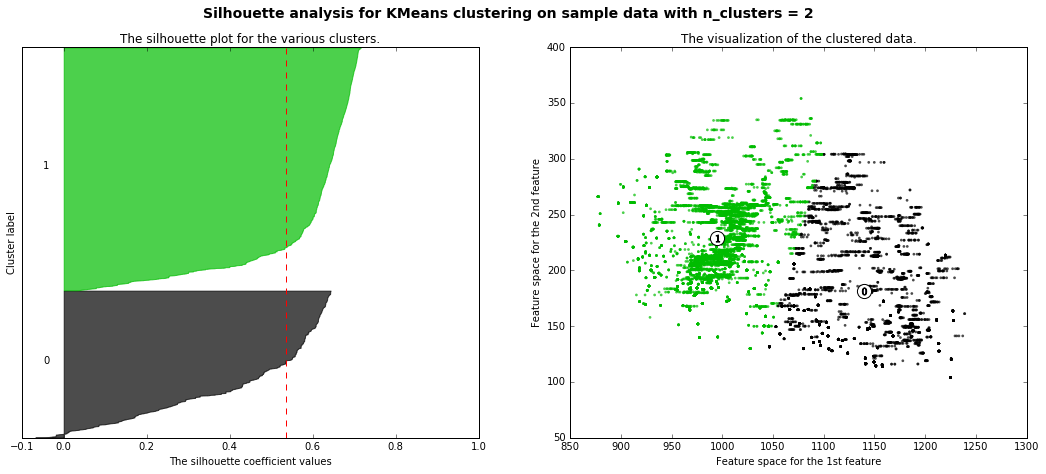

For n_clusters = 3 The average silhouette_score is : 0.464546418847


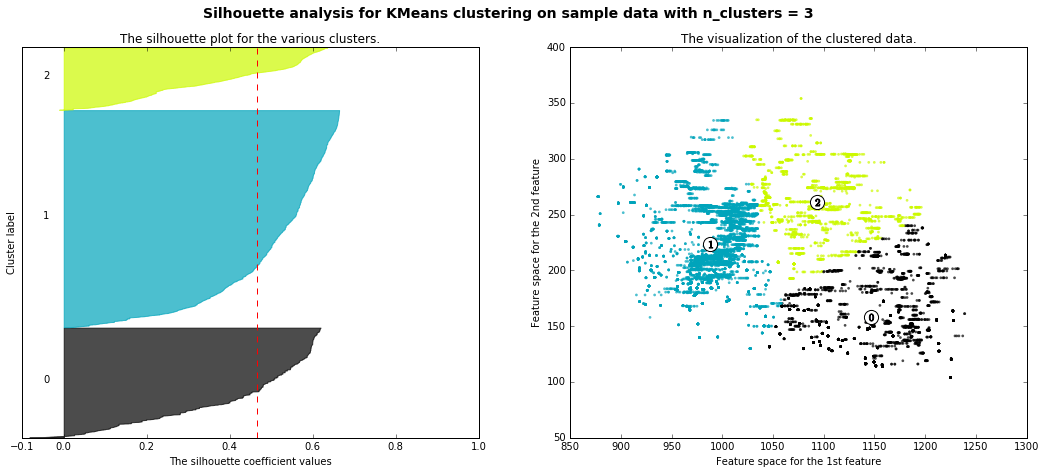

For n_clusters = 4 The average silhouette_score is : 0.45572607359


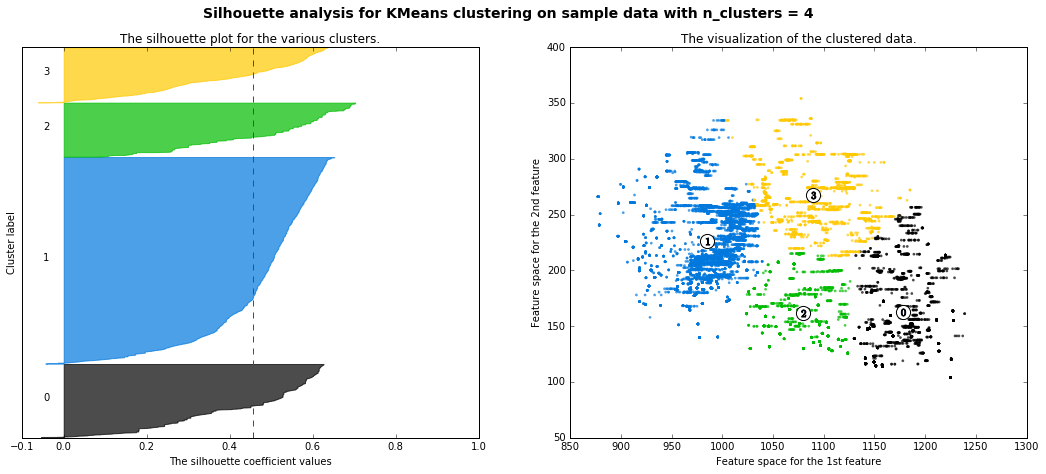

For n_clusters = 5 The average silhouette_score is : 0.41017875407


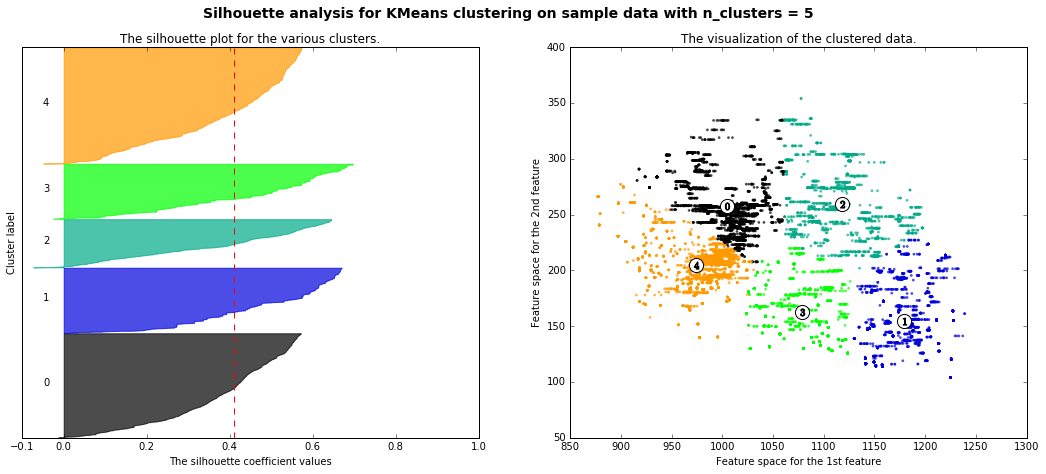

For n_clusters = 6 The average silhouette_score is : 0.428771810452


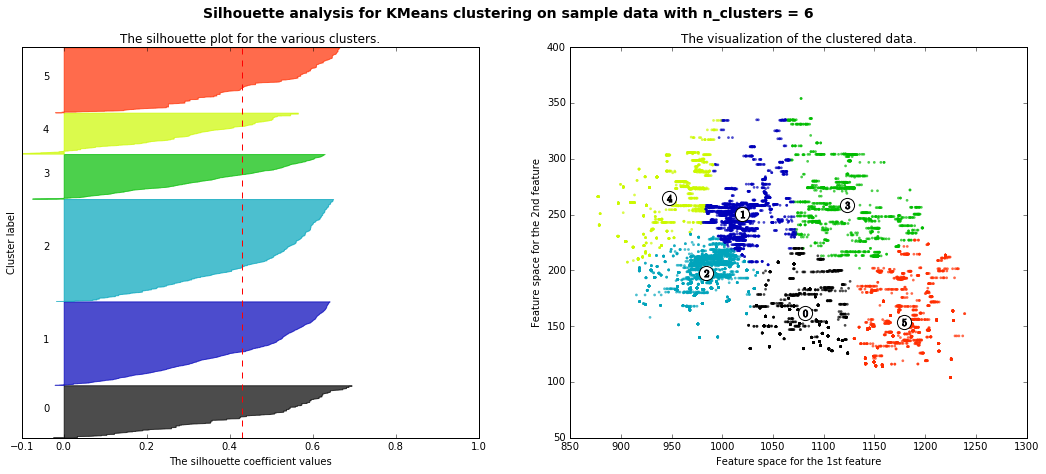

In [61]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

x = x_test


range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x['pr30yr'], x['DEM'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## Classification using the previously determined low, intermediate & high tree cover classes

Classification in this manner was not originally proposed, but since a mixed effects regression and evaulation is still in the works for this project, I chose to also implement classificaiton. Linear regression demonstrates that singular predictors (even precipitation), cant explain the patterns in tree density demonstrated in the tree density histograms. Therefore, I am attempting to use classification

In [358]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import numpy as np
import pandas as pd
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)


from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr','DEM']], X['dens_code'],  test_size=0.20, train_size = 0.80, random_state=42)

h = 1

#x_train
# Fit the model on the training data.

knn.fit(x_train, y_train)
# Make point predictions on the test set using the fit model.
predictions = knn.predict(x_test)

#need to put data into a mesh grid to visualize the separation
x_min, x_max = x_test.pr30yr.min() - .5, x_test.pr30yr.max() + .5
y_min, y_max = x_test.DEM.min() - .5, x_test.DEM.max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])


Z = Z.reshape(xx.shape)
plt.figure()
plt.figure(1, figsize=(4, 3))
plt.set_cmap(plt.cm.Paired)
#plt.pcolormesh(xx, yy,Z)
#plt.pcolormesh(xx,yy, Z)
plt.scatter(x_test[['pr30yr']], x_test[['DEM']], c=y_test[['dens_code']], s=30, cmap='viridis')

# Plot also the training points
plt.xlabel('TSH')
plt.ylabel('TT4')
Z

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [356]:
x_test['pr30yr']

21531    1105.000000
26717    1122.063000
48027    1037.209000
48263     926.116300
38021    1103.162000
52644     968.996900
22739    1104.523000
31331     942.845200
17284     999.315528
891       972.745307
34828    1019.696000
1391     1003.080411
11981     965.175565
6822     1027.673644
54804    1102.682000
32320    1011.300000
45846    1134.710000
38775    1065.728000
38169    1059.209000
8769      990.827573
11305    1229.426379
44947    1062.450000
33251     983.126000
38433    1042.633000
50647    1058.861000
23206    1141.042000
18675     956.008255
32989     994.592100
1006      940.660622
45777    1210.378000
            ...     
47619    1024.040000
735      1021.871724
5711     1003.329392
51720     968.228300
26015    1145.009000
38153    1186.387000
39465    1049.864000
4166      989.655350
48897     976.769000
31068    1004.908000
30555    1014.852000
35448     945.677900
44959    1020.107000
992       937.994637
2604      993.546220
27616    1055.220000
22400     961

In [143]:
y = pd.Series(X['dens_code'])
x = np.array(X[['pr30yr','DEM']])
x

array([[  979.95151026,   257.48551421],
       [  972.51086433,   193.46982652],
       [  979.09875686,   257.48551421],
       ..., 
       [  998.7234    ,   194.38418599],
       [ 1080.155     ,   129.87544632],
       [ 1095.849     ,   136.41829107]])

Based on this analysis, we might rule out k = 5 and k = 6 for clustering these variables because they have unequally sized silhouettes. 

## Regression analyses

Here we first do a simple linear regression to determine if there is a relationship between density across all instances and precipiation. 

Coefficients/slope estimated: 
 [[ 0.24163864]]
Residual sum of squares: 5720.07
Variance score: 0.07
R-squared value: 0.06


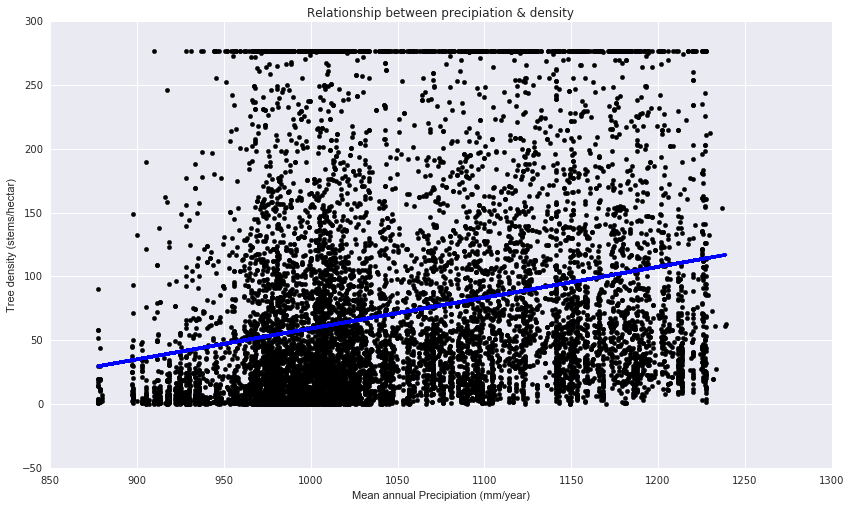

In [509]:
#do simple linear regression in scikit learn
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model


# Split the data into training/testing sets
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['pr30yr']],X[['density']],  test_size=0.20, train_size = 0.80, random_state=42)



# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# The coefficients
print('Coefficients/slope estimated: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

print('R-squared value: %.2f' % regr.score(x_train, y_train))
# Plot outputs
plt.figure( figsize=(14, 8))
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, regr.predict(x_test), color='blue',
         linewidth=3)

#plt.xticks(())
#plt.yticks(())
plt.title("Relationship between precipiation & density")
plt.xlabel("Mean annual Precipiation (mm/year)")
plt.ylabel("Tree density (stems/hectar)")
plt.show()

Linear regression in scikit learn does not calculate significance p-values for the slope, but OLS does:
    

In [506]:
import statsmodels.formula.api as smf

# create a fitted model in one line
lm = smf.ols(formula='density ~ pr30yr', data=X).fit()

# print the coefficients
#lm.params

lm.pvalues
#lm.rsquared

Intercept    0.0
pr30yr       0.0
dtype: float64

## there is no relationship between summer temperature & tree density

Coefficients/slope estimated: 
 [[ 0.10786446]]
Residual sum of squares: 6126.80
Variance score: 0.00
R-squared value: 0.00


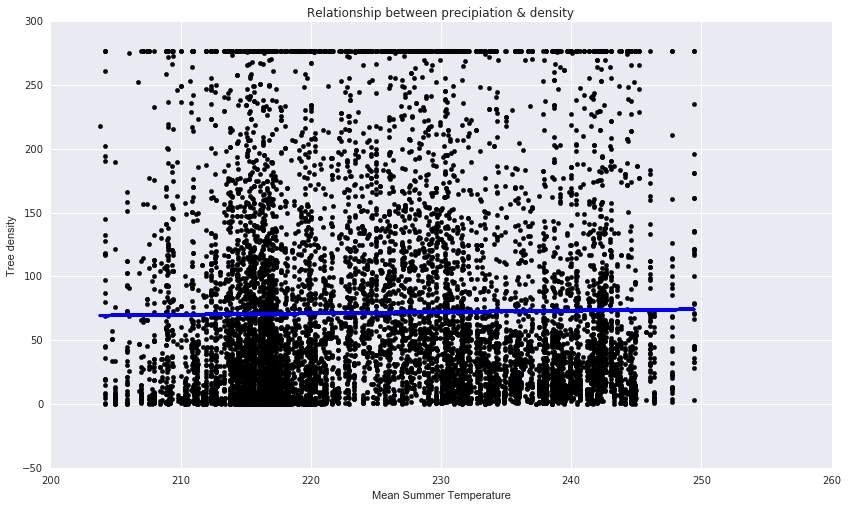

In [452]:
#do simple linear regression in scikit learn
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model


# Split the data into training/testing sets
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['jja_tmean']],X[['density']],  test_size=0.20, train_size = 0.80, random_state=42)



# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# The coefficients
print('Coefficients/slope estimated: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

print('R-squared value: %.2f' % regr.score(x_train, y_train))
# Plot outputs
plt.figure( figsize=(14, 8))
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, regr.predict(x_test), color='blue',
         linewidth=3)

#plt.xticks(())
#plt.yticks(())
plt.title("Relationship between summer temperature & density")
plt.xlabel("Mean Summer Temperature")
plt.ylabel("Tree density")
plt.show()

Coefficients/slope estimated: 
 [[ 0.25197547]]
Residual sum of squares: 6003.05
Variance score: 0.02
R-squared value: 0.02


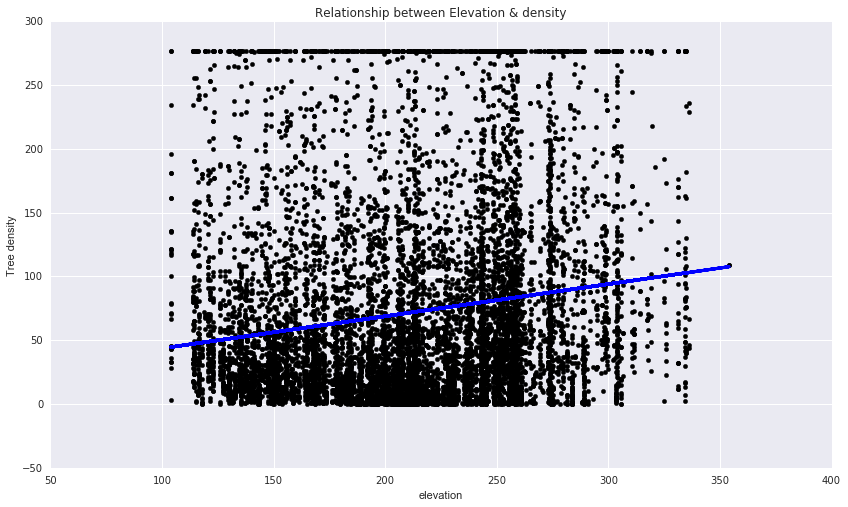

In [456]:
#do simple linear regression in scikit learn
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model


# Split the data into training/testing sets
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['DEM']],X[['density']],  test_size=0.20, train_size = 0.80, random_state=42)



# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# The coefficients
print('Coefficients/slope estimated: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

print('R-squared value: %.2f' % regr.score(x_train, y_train))
# Plot outputs
plt.figure( figsize=(14, 8))
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, regr.predict(x_test), color='blue',
         linewidth=3)

#plt.xticks(())
#plt.yticks(())
plt.title("Relationship between Elevation & density")
plt.xlabel("elevation")
plt.ylabel("Tree density")
plt.show()

Coefficients/slope estimated: 
 [[-0.20816109]]
Residual sum of squares: 6070.59
Variance score: 0.01
R-squared value: 0.01


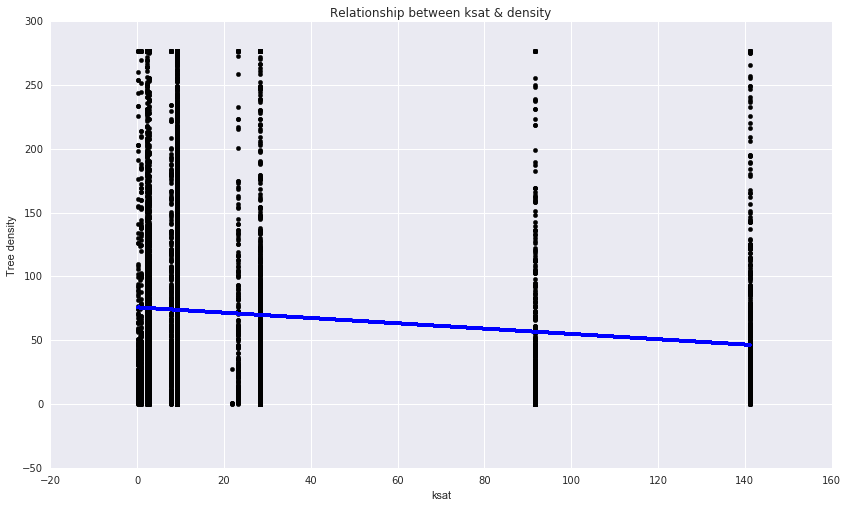

In [455]:
#do simple linear regression in scikit learn
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model


# Split the data into training/testing sets
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X[['ksat']],X[['density']],  test_size=0.20, train_size = 0.80, random_state=42)



# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# The coefficients
print('Coefficients/slope estimated: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

print('R-squared value: %.2f' % regr.score(x_train, y_train))
# Plot outputs
plt.figure( figsize=(14, 8))
plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, regr.predict(x_test), color='blue',
         linewidth=3)

#plt.xticks(())
#plt.yticks(())
plt.title("Relationship between ksat & density")
plt.xlabel("ksat")
plt.ylabel("Tree density")
plt.show()


Because ksat only has a few unique values, it is not a good predictor of density

In general it seems that there is a general increase in tree density with summer precipitation, but there is alot of scatter in the dataset due to the fact that each instance of density is estimated from the diameter, direction & distances to two trees at each of the land surveyors points. This scatter and poor fit is represented by very low R-squared value, making this model not a good predictive model. 


Points can be spatially aggregated up to an 8 km grid cell, but simple averaging over each grid cell ignores spatial variation and may smooth over the sharpness of the boundary. An alternative is to incorporate the grid cell into a linear regression/glm model as a random effect. 

## Regression using spatially aggregated data 

In [173]:
mean_dens= pd.DataFrame(mean_dens)
mean_precip = pd.DataFrame(mean_precip)

x = mean_precip[['pr30yr']]
y = mean_dens[['density']]



Coefficients/slope estimated: 
 [[ 0.3182846]]
Residual sum of squares: 2135.55
Variance score: 0.26
R-squared value: 0.26


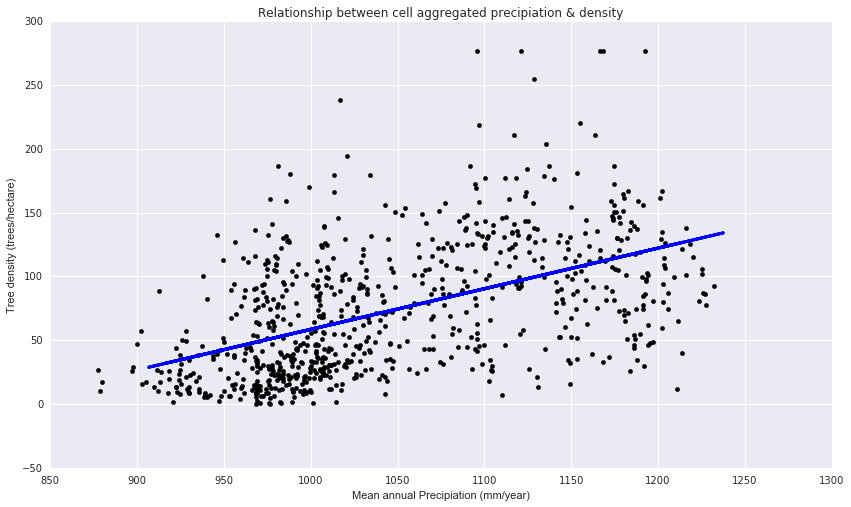

In [508]:
#do simple linear regression in scikit learn
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model


# Split the data into training/testing sets
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mean_precip[['pr30yr']], mean_dens[['density']],  test_size=0.20, train_size = 0.80, random_state=42)



# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# The coefficients
print('Coefficients/slope estimated: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))

print('R-squared value: %.2f' % regr.score(x_train, y_train))
# Plot outputs
plt.figure( figsize=(14, 8))
plt.scatter(x_train, y_train,  color='black')
plt.plot(x_test, regr.predict(x_test), color='blue',
         linewidth=3)

#plt.xticks(())
#plt.yticks(())
plt.title("Relationship between cell aggregated precipiation & density")
plt.xlabel("Mean annual Precipiation (mm/year)")
plt.ylabel("Tree density (trees/hectare)")
plt.show()

In [507]:
# create a fitted model in one line
lm = smf.ols(formula='density ~ pr30yr', data=mean_dens).fit()

# print the coefficients
#lm.params

lm.pvalues
#lm.rsquared

Intercept    5.059779e-44
pr30yr       6.800889e-68
dtype: float64

The relationship between tree density and precipitation is improved when we look at the aggredated data, the relationship has amuch higer R-squared value compared to the unaggregated data

## Modeling with random effects (still a work in progress for the academic paper, but will probably use R)

Much of the bayesian framework for modeling with randome effects is drawn from code found in the following sites:

    http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/
    http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/
        
Additional statistical references used include:

    Lynch, S.M. Intoduction to Applied Bayesian Statistics and Estimation for Social Scientists
    
    Pinheiro, J.C., and Bates, D.M. Mixed-Effects Models in S and S-Plus



In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from pymc3 import glm, Model, Metropolis, NUTS, sample
import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np

import theano
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter("ignore", SettingWithCopyWarning)

#X = pd.DataFrame(X[['precip','density']])

In [185]:
#create a new serires of ids for the cell numbers from 0 -990    
cell_names = X.cell.unique()

#create a lookup table to link cell numbers to the look up values
cell_lookup = dict(zip(cell_names, range(len(cell_names))))

#there are 991 unique cells in this dataset
n_counties = len(X.cell.unique())

#use lookup table to create indices for modeling
cells = X['cell_code'] = X.cell.replace(cell_lookup).values

spec_names = X.spec_dum.unique()

#create a lookup table to link cell numbers to the look up values
spec_lookup = dict(zip(spec_names, range(len(spec_names))))
specs = X['spec_code'] = X.spec_dum.replace(spec_lookup).values


density = X.density
X['log_density'] = log_density = np.log(density + 0.1).values
precip = X.pr30yr
specs

array([ 0,  1,  2, ..., 11,  3,  3], dtype=int64)

In [252]:
#can run a statsmodel with groups (random effects model) using 'cell' as our random effect, but not species (see next cell)????????
import statsmodels.api as sm 
import statsmodels.formula.api as smf

data = X[['density','pr30yr', 'cell_code', 'cell']]
data.head()
mod_lme = smf.MixedLM.from_formula("density ~ pr30yr", groups=data['cell'], data = data)
result= mod_lme.fit(data)
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM  Dependent Variable:  density     
No. Observations:   55052    Method:              REML        
No. Groups:         991      Scale:               4353.7358   
Min. group size:    2        Likelihood:          -310054.5521
Max. group size:    224      Converged:           Yes         
Mean group size:    55.6                                      
--------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------
Intercept    -184.073   16.963 -10.852 0.000 -217.319 -150.826
pr30yr          0.247    0.016  15.296 0.000    0.215    0.278
Intercept RE 1553.191    1.248                                
==============================================================

"""

#### As a comparison, here is the output from the same model fit in R using the lme4 package:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: density ~ pr30yr + (1 | cell)
   Data: spec.table

      AIC       BIC    logLik  deviance  df.resid 
 627354.7  627390.4 -313673.4  627346.7     55694 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3555 -0.5708 -0.2416  0.2525  3.9860 

Random effects:

 Groups   Name        Variance Std.Dev.
 
 
 cell     (Intercept) 1556     39.45   
 
 
 Residual             4350     65.95   
Number of obs: 55698, groups:  cell, 1013

Fixed effects:
              Estimate Std. Error t value
(Intercept) -230.20139   16.55052  -13.91
pr30yr         0.29084    0.01575   18.46

Correlation of Fixed Effects:
       (Intr)
pr30yr -0.997

In [243]:
#actually can't figure out why this works because the warning traceback provides no information about why I cant use spec_dum
import statsmodels.api as sm 
import statsmodels.formula.api as smf

data2 = X[['density','pr30yr', 'spec_dum']]
data2.head()
mod_lme2 = smf.MixedLM.from_formula("density ~ pr30yr", groups=data['spec_dum'], data = data)
result2= mod_lme2.fit(data2)
#print result2.summary()


KeyError: 'spec_dum'

In [246]:
data.head()

density       pr30yr  cell_code
1   86.200602   979.951510          0
2  276.743474   972.510864          1
3  174.552618   979.098757          0
4   20.270470  1000.790791          2
5    0.232335   969.614074          3

In [189]:
#from pymc3 import glm, Model, Metropolis, NUTS, sample
import pymc3 as pm

import matplotlib.pyplot as plt
import numpy as np

import theano
x = X[['pr30yr']]
y = X[['density']]
data = dict(x=x, y=y)

with pm.Model() as model:
    pm.glm.glm('y ~ x', data)
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling=start)
    trace = pm.sample(1000, pm.NUTS(), progressbar=True)
    

Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 1000 of 1000 complete in 48.9 sec

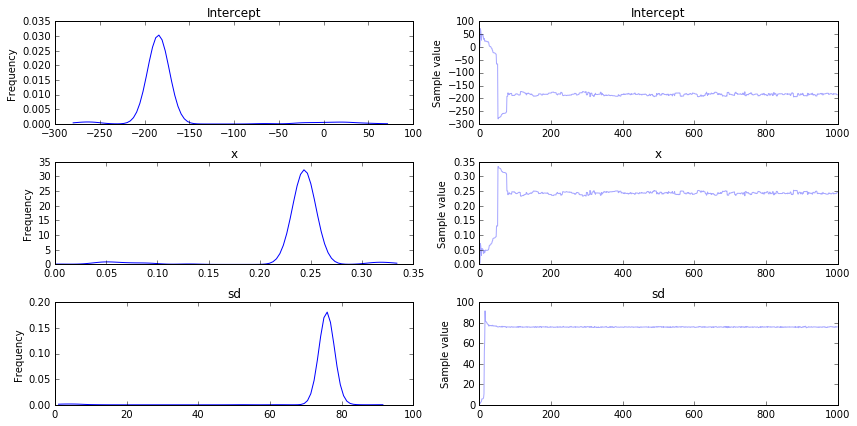

In [190]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout();


# Plotting the posterier prediction of density ~ precipitation GLM

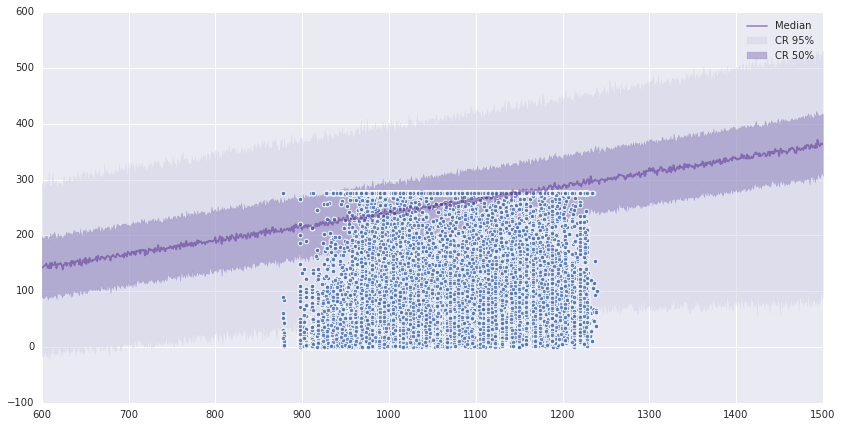

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns  

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['sd']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X2 = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X2,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(14,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':20, 'lw':1,'edgecolor':'w'}, ax=ax1d)

#xlims = (data['x'].min() - np.ptp(data['x'])/10  
 #                ,data['x'].max() + np.ptp(data['x'])/10)

plot_posterior_cr(model, trace, data, xlims= (600,1500))

The GLM estimates a similar slope compared to the original OLS regression, but the intercepts are different in the two analyses

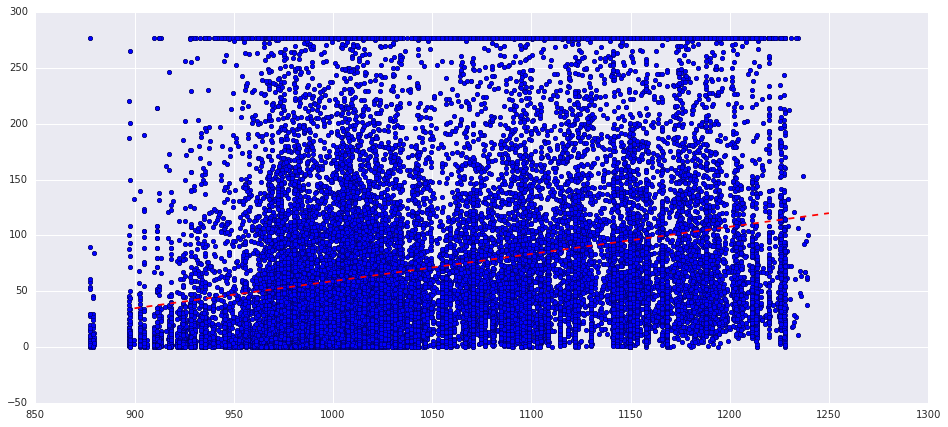

In [192]:
plt.figure(figsize = (16,7))
#now plot the linear pooled regression
b0, m0 = trace['Intercept'][500:].mean(), trace['x'][500:].mean()
plt.scatter(X[['pr30yr']], X[['density']])
xvals = np.linspace(900, 1250)
plt.plot(xvals, m0*xvals+b0, 'r--')



In [193]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf

md = smf.mixedlm('density ~ pr30yr', X, groups=X['spec_dum']) 
mdf = md.fit() 

mdf

MemoryError: 

Notice that the GLM also generates a linear regression with poor fit to the large dataset. We can also model a GLM without the patsy y ~ x notation, as follwos:

In [205]:
with pm.Model() as no_pooling:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of density using all the data and no cell random effects
   
    density_est = a + b * precip
    
    # Data likelihood
    density_like = pm.Normal('density_like', mu=density_est, sd=eps, observed=density)


Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval_ to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval_ to model.
Applied interval-transform to eps and added transformed eps_interval_ to model.


In [206]:
from pymc3 import sample

with no_pooling:
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=partial_pooling.dict_to_array(sds)**2, 
                   is_cov=True)
    no_pooling_trace = pm.sample(5000, step, start=mu)

Iteration 0 [0%]: ELBO = -3359455.03
Iteration 10000 [10%]: Average ELBO = -4259503.19
Iteration 20000 [20%]: Average ELBO = -335904.87
Iteration 30000 [30%]: Average ELBO = -317817.38
Iteration 40000 [40%]: Average ELBO = -317388.9
Iteration 50000 [50%]: Average ELBO = -317355.37
Iteration 60000 [60%]: Average ELBO = -317327.98
Iteration 70000 [70%]: Average ELBO = -317302.14
Iteration 80000 [80%]: Average ELBO = -317275.01
Iteration 90000 [90%]: Average ELBO = -317249.69
Finished [100%]: Average ELBO = -317223.61
 [-----------------100%-----------------] 5000 of 5000 complete in 315.8 sec

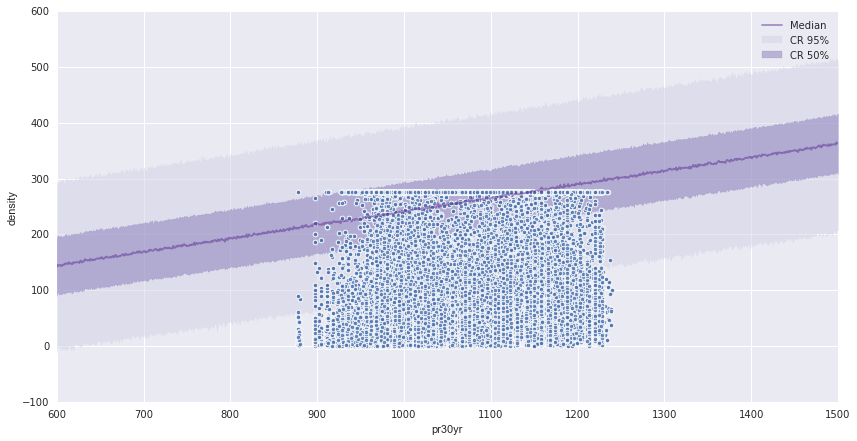

In [208]:
def plot_posterior_advi(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['alpha','beta']]
    trc_sd = pm.trace_to_dataframe(trc)['eps']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X2 = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X2,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(14,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='pr30yr', y='density', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':20, 'lw':1,'edgecolor':'w'}, ax=ax1d)

#xlims = (data['x'].min() - np.ptp(data['x'])/10  
 #                ,data['x'].max() + np.ptp(data['x'])/10)


plot_posterior_advi(no_pooling, no_pooling_trace, X[['pr30yr', 'density']] , xlims= (600,1500))

In [22]:
#len(set(X['cell']))
len(set(X['cell']))

991

## Partial pooling model

​

This simple partial pooling model does not include precipitation as a predictor, but simple models the density based on the weighted means of each grid cell. So this model is really just a random effects model for density. Here we are modeling the density as being distributed normally, which I am not sure is a correct assumption

​

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

In [194]:
from pymc3 import Normal, Model, Uniform

with Model() as partial_pooling:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(X['cell'])))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[cells]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=X.density[cells])

Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.


In [195]:

from pymc3 import sample

with partial_pooling:
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=partial_pooling.dict_to_array(sds)**2, 
                   is_cov=True)
    hm_trace = pm.sample(5000, step, start=mu)


Iteration 0 [0%]: ELBO = -379743.45
Iteration 10000 [10%]: Average ELBO = -416801.88
Iteration 20000 [20%]: Average ELBO = -347954.22
Iteration 30000 [30%]: Average ELBO = -345378.38
Iteration 40000 [40%]: Average ELBO = -343945.6
Iteration 50000 [50%]: Average ELBO = -342589.16
Iteration 60000 [60%]: Average ELBO = -341263.6
Iteration 70000 [70%]: Average ELBO = -339979.56
Iteration 80000 [80%]: Average ELBO = -338726.52
Iteration 90000 [90%]: Average ELBO = -337514.32
Finished [100%]: Average ELBO = -336339.04
 [-----------------100%-----------------] 5000 of 5000 complete in 438.1 sec

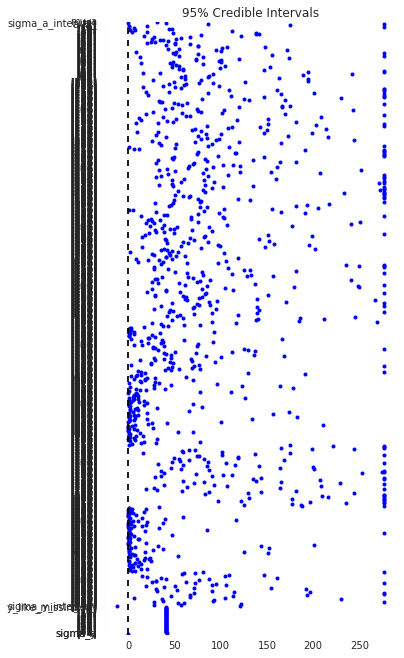

In [196]:
plt.figure(figsize=(6,10))
pm.forestplot(hm_trace)

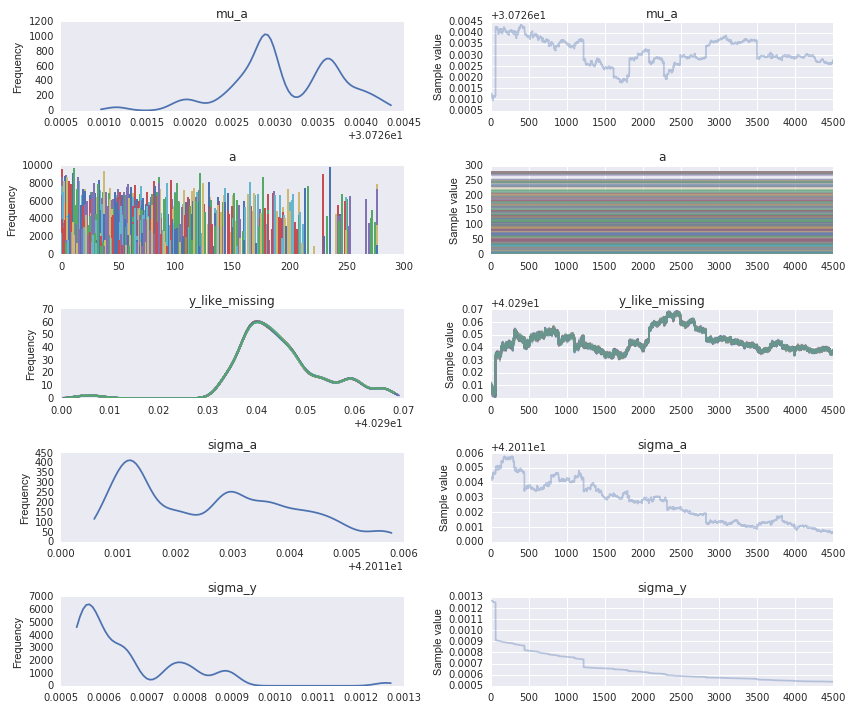

In [197]:
pm.traceplot(hm_trace[500:]);

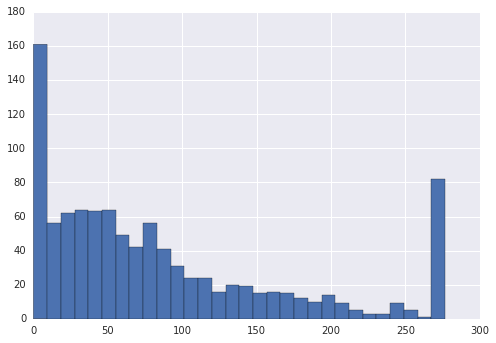

In [237]:
b = pd.DataFrame(hm_trace['a'].mean(axis=0))
cell_density_ests= pd.DataFrame(hm_trace['a'])
conv= cell_density_ests[1500:].mean(axis=0)
conv.hist(bins = 30)

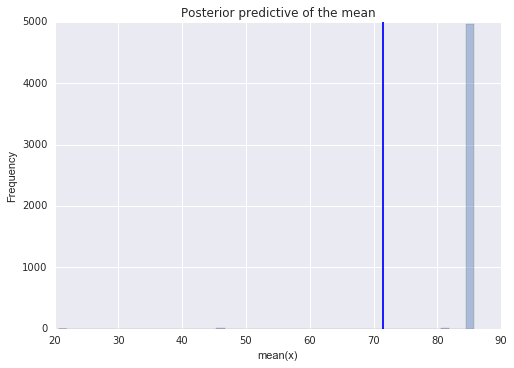

In [241]:
ax = plt.subplot()
sns.distplot([a.mean() for a in hm_trace['a']], kde=False, ax=ax)
ax.axvline(X['density'].mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

There is less of a bimodal distribution in the predicted trace values of denisty than in the dataset & the mean in the posterior predictive distribution is much higher than the mean of the dataset. Since the model did not converge for some parameters, we likely can't use this as a good model

In [209]:
with pm.Model() as partial_pooling:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(set(X.cell)))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(set(X.cell)))
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    density_est = a[cells] + b[cells] * precip
    
    # Data likelihood
    density_like = pm.Normal('density_like', mu=density_est, sd=eps, observed=density)


Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval_ to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval_ to model.
Applied interval-transform to eps and added transformed eps_interval_ to model.


In [210]:
#this takes a long time
from pymc3 import sample

with partial_pooling:
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=partial_pooling.dict_to_array(sds)**2, 
                   is_cov=True)
    hm_trace = pm.sample(5000, step, start=mu)


Iteration 0 [0%]: ELBO = -4585149.74
Iteration 10000 [10%]: Average ELBO = -4141519.51
Iteration 20000 [20%]: Average ELBO = -332474.61
Iteration 30000 [30%]: Average ELBO = -311732.98
Iteration 40000 [40%]: Average ELBO = -310343.02
Iteration 50000 [50%]: Average ELBO = -310306.34
Iteration 60000 [60%]: Average ELBO = -310304.95
Iteration 70000 [70%]: Average ELBO = -310305.51
Iteration 80000 [80%]: Average ELBO = -310306.39
Iteration 90000 [90%]: Average ELBO = -310305.98
Finished [100%]: Average ELBO = -310306.65
 [-----------------100%-----------------] 5001 of 5000 complete in 1100.3 sec

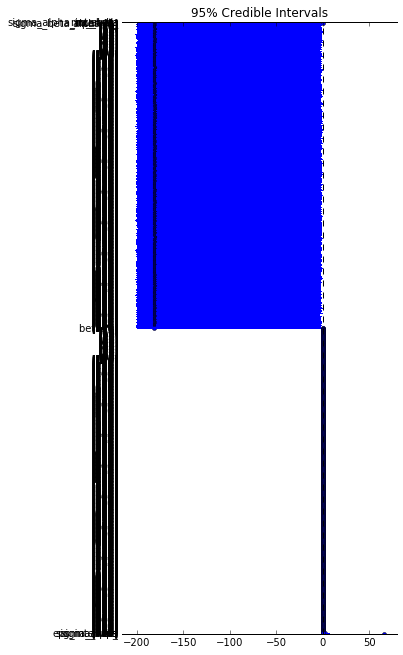

In [22]:
#from pymc3 import forestplot

plt.figure(figsize=(6,10))
pm.forestplot(hm_trace) #, vars=['slope', 'intercept'])

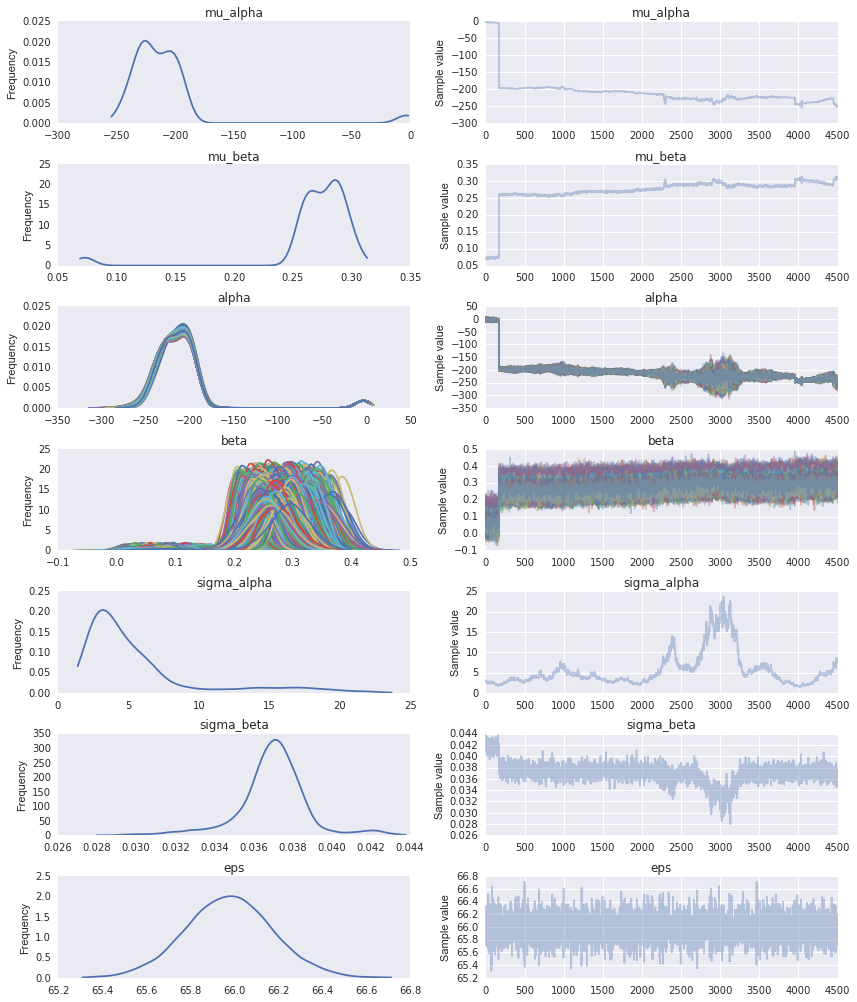

In [211]:
pm.traceplot(hm_trace[500:]);

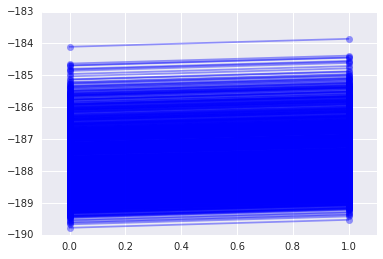

In [212]:
xvals = np.arange(2)
bp = hm_trace['alpha'].mean(axis=0)
mp = hm_trace['beta'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);


## Heirarchical model with varing slope and intercept (in theory)

We allow both the slope of the relationship of density & climate to vary by cell & the intercept to vary by cell:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [8]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(set(X.cell)))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(set(X.cell)))
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    density_est = a[cells] + b[cells] * precip
    
    # Data likelihood
    density_like = pm.Normal('density_like', mu=density_est, sd=eps, observed=log_density)

Applied interval-transform to sigma_alpha and added transformed sigma_alpha_interval_ to model.
Applied interval-transform to sigma_beta and added transformed sigma_beta_interval_ to model.
Applied interval-transform to eps and added transformed eps_interval_ to model.


Sample from Heirarchical Model

In [9]:
with hierarchical_model:
    
    step = pm.NUTS()
    
    hierarchical_trace = pm.sample(2000, step)

 [-                 3%                  ] 60 of 2000 complete in 637.8 sec

In [ ]:
pm.traceplot(hierarchical_trace[500:]);

In [ ]:
xvals = np.arange(2)
bp = varying_intercept_samples['a'].mean(axis=0)
mp = varying_intercept_samples['b'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

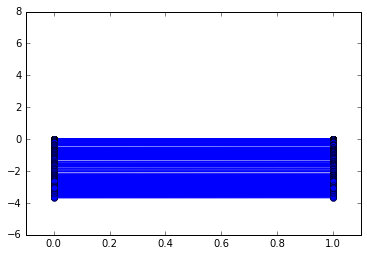

In [90]:
xvals = np.arange(2)
bp = hierarchical_trace['alpha'].mean(axis=1)
mp = hierarchical_trace['beta'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

plt.scatter(X[['precip']], log_density)

In [11]:
# Inference button (TM)!
with hierarchical_model:
    # Use ADVI for initialization
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=hierarchical_model.dict_to_array(sds)**2, 
                   is_cov=True)
    hierarchical_trace = pm.sample(5000, step, start=mu)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '10148' (I am process '4840')


Iteration 0 [0%]: ELBO = -4401078.56
Iteration 10000 [10%]: Average ELBO = -3992163.17
Iteration 20000 [20%]: Average ELBO = -314590.13
Iteration 30000 [30%]: Average ELBO = -237169.95
Iteration 40000 [40%]: Average ELBO = -135003.19
Iteration 50000 [50%]: Average ELBO = -97705.54
Iteration 60000 [60%]: Average ELBO = -93748.27
Iteration 70000 [70%]: Average ELBO = -93423.69
Iteration 80000 [80%]: Average ELBO = -93350.27
Iteration 90000 [90%]: Average ELBO = -93320.65
Finished [100%]: Average ELBO = -93306.82
 [-----------------100%-----------------] 5001 of 5000 complete in 6123.1 sec

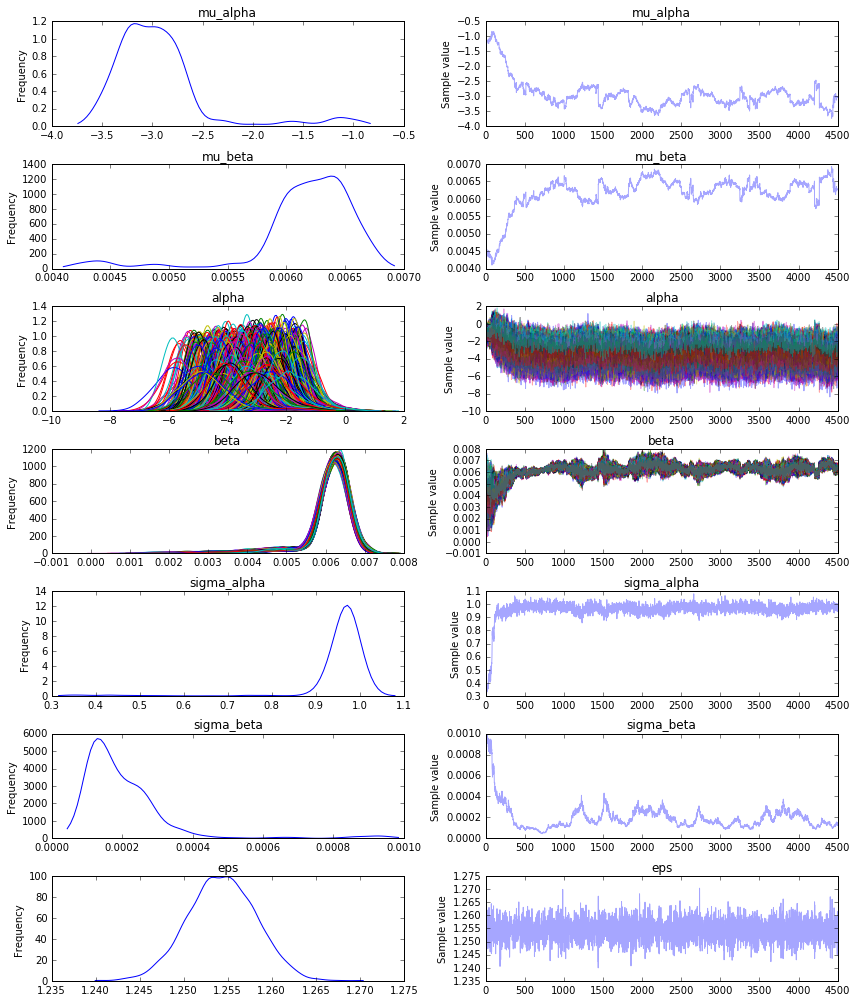

In [12]:
pm.traceplot(hierarchical_trace[500:]);

In [13]:
print(pm.df_summary(hierarchical_trace[-1000:]))  

                 mean        sd  mc_error   hpd_2.5  hpd_97.5
mu_alpha    -3.063286  0.259983  0.025224 -3.596519 -2.647025
mu_beta      0.006286  0.000250  0.000024  0.005916  0.006842
alpha__0    -1.894651  0.354692  0.025215 -2.559645 -1.189138
alpha__1    -2.605125  0.346591  0.025335 -3.255435 -1.968039
alpha__2    -3.190712  0.325493  0.024650 -3.799833 -2.562506
alpha__3    -4.477139  0.331936  0.024686 -5.158902 -3.907392
alpha__4    -3.488233  0.385611  0.026342 -4.208693 -2.735484
alpha__5    -2.439573  0.319035  0.023786 -3.097051 -1.858240
alpha__6    -4.511500  0.378499  0.025714 -5.213080 -3.806715
alpha__7    -2.669247  0.324487  0.023698 -3.277846 -2.040828
alpha__8    -3.397723  0.374098  0.026051 -4.150729 -2.743360
alpha__9    -3.825957  0.384213  0.027703 -4.574667 -3.137978
alpha__10   -5.038296  0.367057  0.027714 -5.689752 -4.322482
alpha__11   -2.084471  0.337309  0.024675 -2.768133 -1.499002
alpha__12   -4.181414  0.354090  0.027278 -4.897026 -3.556352
alpha__1

In [19]:
def plot_traces(trcs, retain=1000, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''
    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
    ax = pm.traceplot(trcs[-retain:], varnames=varnames, figsize=(12,nrows*1.4)
        ,lines={k: v['mean'] for k, v in 
            pm.df_summary(trcs[-retain:],varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs[-retain:], varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')    

IndexError: index 7 is out of bounds for axis 0 with size 7

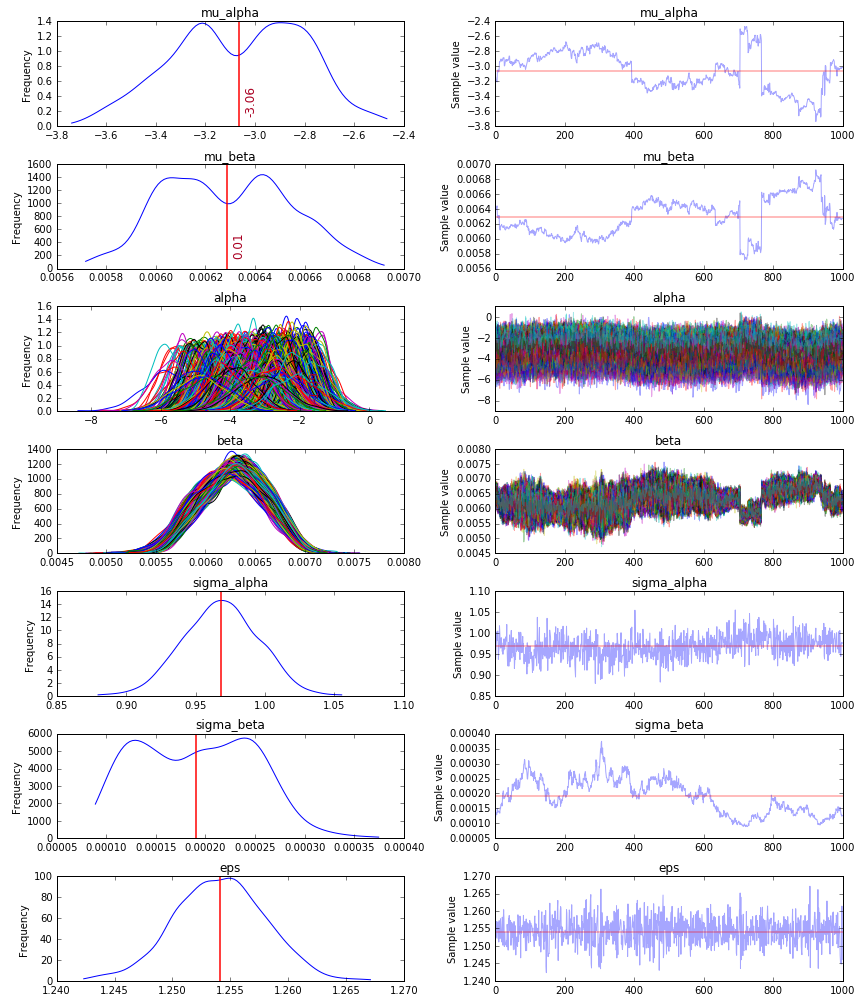

In [20]:
plot_traces(hierarchical_trace[500:])

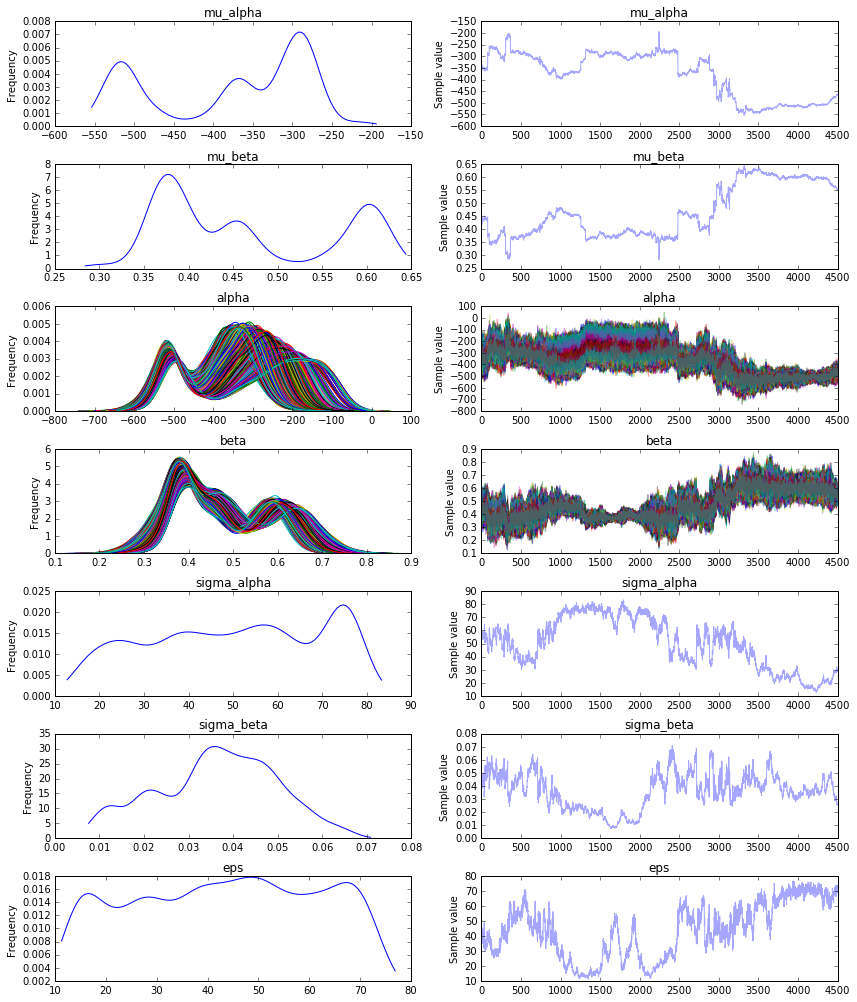

In [65]:
pm.traceplot(hierarchical_trace[500:]);

## Varying intercept model

This model has a random effect that allows the intecept to vary across grid cells.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$



In [213]:
with pm.Model() as varying_intercept:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    
    # Random intercepts
    a = pm.Normal('a', mu=mu_a, tau=tau_a, shape=len(set(X.cell)))
    # Common slope
    b = pm.Normal('b', mu=0., tau=0.0001)
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[cells] + b * precip
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, tau=tau_y, observed=log_density)

Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.


In [214]:
with varying_intercept:
    
    step = pm.NUTS()
    
    varying_intercept_samples = pm.sample(2000, step)

 [-----------------100%-----------------] 2000 of 2000 complete in 151.5 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000008E7D82E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000AD85F208>]], dtype=object)

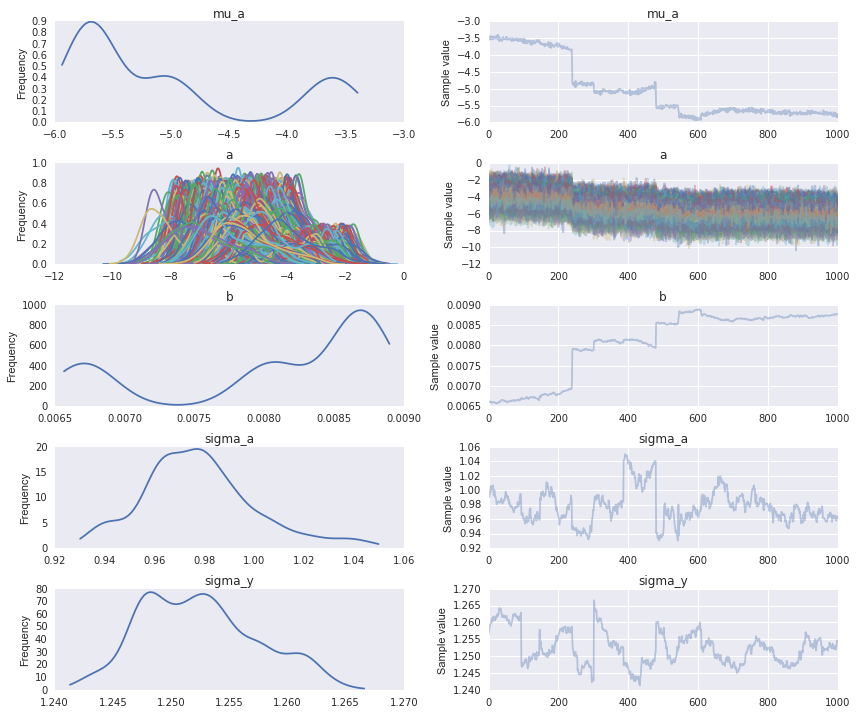

In [215]:
from pymc3 import traceplot

traceplot(varying_intercept_samples[-1000:])

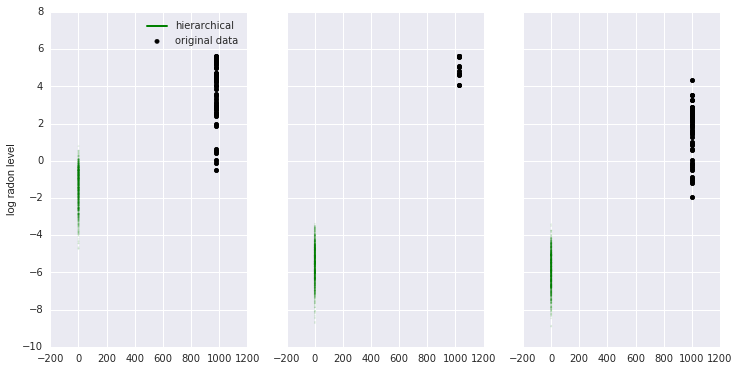

In [216]:
selection = [1, 100, 110]
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = X.ix[X.cell_code == c]
    c_data = c_data.reset_index(drop = True)
    z = list(c_data['cell_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    #for a_val, b_val in zip(indiv_traces[c]['alpha'][500::10], indiv_traces[c]['beta'][500::10]):
     #   axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    #axis[i].plot(xvals, indiv_traces[c]['alpha'][500::10].mean() + indiv_traces[c]['beta'][500::10].mean() * xvals, 
     #            'b', alpha=1, lw=2., label='individual')
    for a_val,b_val in zip(varying_intercept_samples['a'][500::10][z], varying_intercept_samples['b'][500:]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, varying_intercept_samples['a'][500::10][z].mean() + varying_intercept_samples['b'][500:].mean() * xvals, 
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_data.precip + np.random.randn(len(c_data))*0.01, c_data.log_density, 
                    alpha=1, color='k', marker='.', s=80, label='original data')
    #axis[i].set_xticks([0,1])
    # axis[i].set_xticklabels(['basement', 'no basement'])
    #axis[i].set_ylim(-1, 4)
    #axis[i].set_title(c)
    if not i%3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In [37]:
#from pymc3 import summary

#summary(varying_intercept_samples[-1000:])

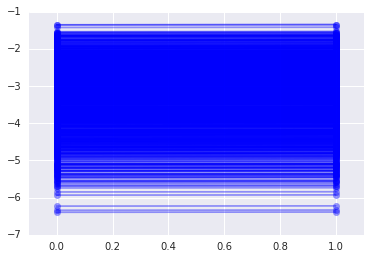

In [217]:
xvals = np.arange(2)
bp = varying_intercept_samples['a'].mean(axis=0)
mp = varying_intercept_samples['b'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

Note that the varying intercept model can be interperted in terms of my data as modeling a different intercept for each cell, but the overall slope of the relationship between climate & density remains the same. This is not quite what we are interested in, since we are interested in modeling the relationship between climate and density to determine the cells where density is well explained by climate (high positive slope), and those cells where density is not well explained by climate (flat slope/no relationship). 

In [298]:
with pm.Model() as varying_slope:
    
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., tau=0.0001)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    
    # Model intercept
    a = pm.Normal('a', mu=0., tau=0.0001)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, tau=tau_b, shape=len(set(X.cell)))
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a + b[X.spec_dum] * precip
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, tau=tau_y, observed=log_density)
    
    e_y = y_like - y_hat

Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.


precip1       precip       ksat     density   cell       x       y  \
0  1032.301697  1032.301697  28.228701   86.200602  35035  781000  550000   
1   979.158333   979.158333  28.228701  276.743474  34136  693000  574000   
2  1032.301697  1032.301697  28.228701  174.552618  35035  781000  550000   
3   978.335709   978.335709  28.228701   20.270470  34143  749000  574000   
4   949.267449   949.267449  91.743202    0.232335  36794  645000  502000   

   index_x  ids_x  index_y  ids_y  
0        0      0        0      0  
1        1      1        1      1  
2        0      0        0      0  
3        2      2        2      2  
4        3      3        3      3

In [299]:
with varying_slope:
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=varying_slope.dict_to_array(sds)**2,
    is_cov=True)
    varying_slope_samples = pm.sample(2000, step, start=mu)

Iteration 0 [0%]: ELBO = -3419302.57
Iteration 10000 [10%]: Average ELBO = -4148225.85
Iteration 20000 [20%]: Average ELBO = -310237.29
Iteration 30000 [30%]: Average ELBO = -227405.62
Iteration 40000 [40%]: Average ELBO = -124354.47
Iteration 50000 [50%]: Average ELBO = -99737.52
Iteration 60000 [60%]: Average ELBO = -98566.49
Iteration 70000 [70%]: Average ELBO = -98487.47
Iteration 80000 [80%]: Average ELBO = -98461.9
Iteration 90000 [90%]: Average ELBO = -98432.81
Finished [100%]: Average ELBO = -98412.54
 [-----------------100%-----------------] 2000 of 2000 complete in 448.4 sec

In [226]:
e_y

Elemwise{sub,no_inplace}.0

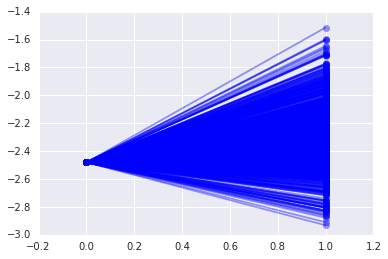

In [300]:
xvals = np.arange(2)
b = varying_slope_samples['a'].mean()
m = varying_slope_samples['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000076F20898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000C1F2BB38>]], dtype=object)

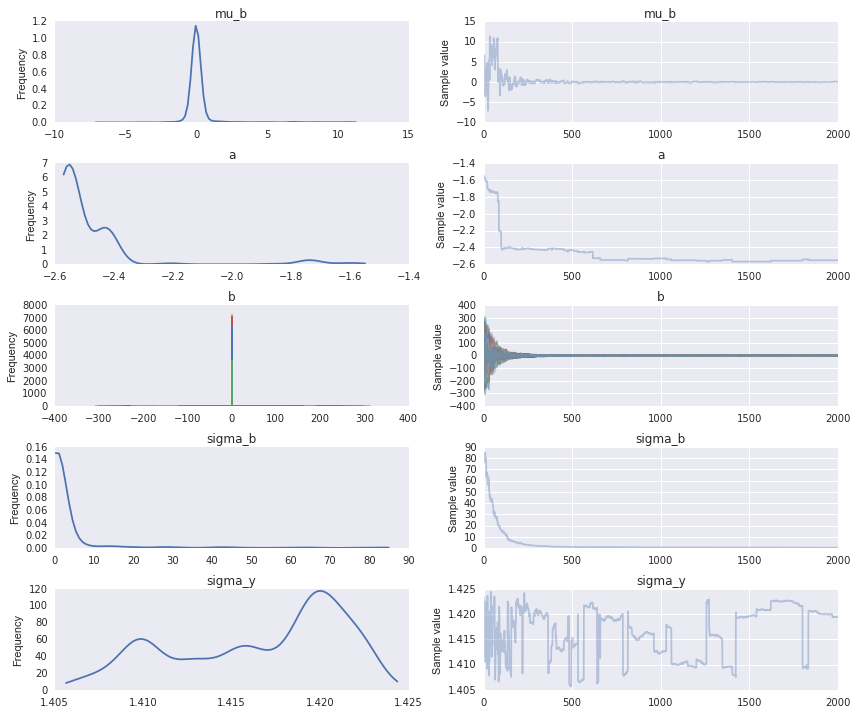

In [301]:
traceplot(varying_slope_samples)

In [94]:
with Model() as varying_intercept_slope:
    
    # Priors    
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    mu_b = Normal('mu_b', mu=0., tau=0.0001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(X.cell)))
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(X.cell)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[ids] + b[ids] * X.precip[ids]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=X.density[ids])

Applied interval-transform to sigma_a and added transformed sigma_a_interval_ to model.
Applied interval-transform to sigma_b and added transformed sigma_b_interval_ to model.
Applied interval-transform to sigma_y and added transformed sigma_y_interval_ to model.


In [ ]:
with varying_intercept_slope:
    
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=varying_intercept_slope.dict_to_array(sds)**2,
    is_cov=True)
    varying_intercept_slope_samples = pm.sample(2000, step, start=mu)

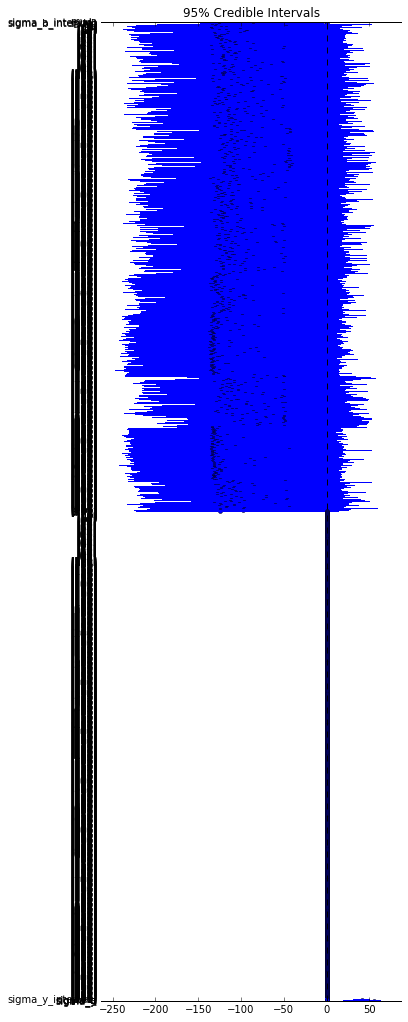

In [75]:
plt.figure(figsize=(6,16))
pm.forestplot(varying_intercept_slope_samples) #, vars=['a','b'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000086A76F98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000D75646D8>]], dtype=object)

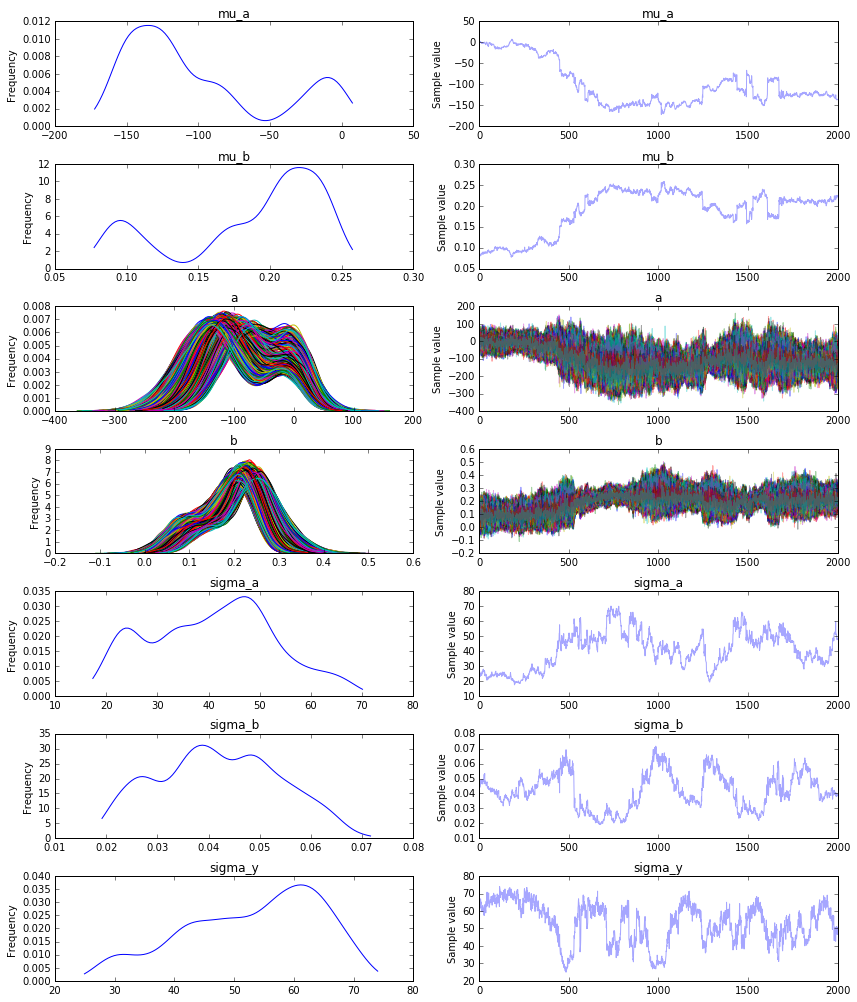

In [76]:
traceplot(varying_intercept_slope_samples)

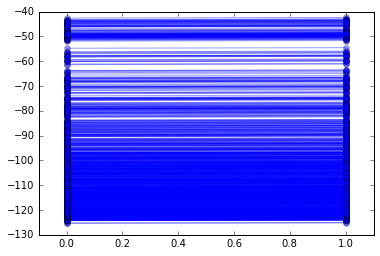

In [83]:
xvals = np.arange(2)
b = varying_intercept_slope_samples['a'].mean(axis=0)
m = varying_intercept_slope_samples['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);
